## shNfkb components
12/15/25 - Data generated from shNfkb single hairpin experiments (canonical Nfkb); tumors harvested from KP RIK mice at 17 weeks post tumor induction after 1 week of doxycycline treatment; data submitted by Jason/ERH/Selena/CHP on 1/19/2024.

Analyze global run on cellranger v6 data and create h5_ad files for further analysis

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

import math
import matplotlib
from matplotlib import pyplot as plt

from pathlib import Path
import anndata

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
np.random.seed(1573)   #fix so we can reproduce later

In [3]:
results_file = 'write/IGO15770-shNfkb.h5ad'  # the file that will store the analysis results

In [4]:
#Path("./figures").mkdir(parents=True, exist_ok=True) # generate figures here
Path("./write").mkdir(parents=True, exist_ok=True) # write h5ad here

In [5]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.family"] = "Arial"

In [6]:
adata = sc.read_10x_h5('IGO15770-filtered_feature_bc_matrix.h5', gex_only=False)

reading IGO15770-filtered_feature_bc_matrix.h5
 (0:00:00)


/home/chanj2/part2a/lib/python3.11/site-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [7]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [8]:
library = ["2117-Nfkb1.2331","2118-Nfkb1.3737",'JCP628-shIkbkg-1.2526','JCP629-shIkbkg-2.2984',
           'JCP618-shRela-1.1202','JCP621-shRela-4.1182','JCP623-shRel-1.1868',
           'JCP625-shRel-3.342','Ikbsr-FLAG','shRenilla']

In [9]:
samples = list(adata[:,adata.var['feature_types']=='Antibody Capture'].var.index)

In [10]:
print(samples)

['BE1156_(BD1671)_B0301', 'BE1155_(BD1672)_B0302', 'BD1939_B0303', 'BE1137_B0304', 'BE1157_(BD1674)_B0305', 'BD1941_B0306', 'BE1139_B0307', 'BE1140-NT_B0308', 'BE1490_B0309', 'BE1491-NT_B0310', 'BE1662_B0311', 'BF1240_(BE1834)_B0312', 'BF1087_B0313']


In [11]:
# Now filter out barcodes
hashadata = adata[:,samples]
adata = adata[:,[y for y in adata.var_names if y not in samples]]

In [12]:
hashadata.var

gene_ids     feature_types genome  \
BE1156_(BD1671)_B0301  BE1156_(BD1671)_B0301  Antibody Capture          
BE1155_(BD1672)_B0302  BE1155_(BD1672)_B0302  Antibody Capture          
BD1939_B0303                    BD1939_B0303  Antibody Capture          
BE1137_B0304                    BE1137_B0304  Antibody Capture          
BE1157_(BD1674)_B0305  BE1157_(BD1674)_B0305  Antibody Capture          
BD1941_B0306                    BD1941_B0306  Antibody Capture          
BE1139_B0307                    BE1139_B0307  Antibody Capture          
BE1140-NT_B0308              BE1140-NT_B0308  Antibody Capture          
BE1490_B0309                    BE1490_B0309  Antibody Capture          
BE1491-NT_B0310              BE1491-NT_B0310  Antibody Capture          
BE1662_B0311                    BE1662_B0311  Antibody Capture          
BF1240_(BE1834)_B0312  BF1240_(BE1834)_B0312  Antibody Capture          
BF1087_B0313                    BF1087_B0313  Antibody Capture          

                                         pattern read         sequence  
BE1156_(BD1671)_B0301  5PNNNNNNNNNN(BC)NNNNNNNNN   R2  ACCCACCAGTAAGAC  
BE1155_(BD1672)_B0302  5PNNNNNNNNNN(BC)NNNNNNNNN   R2  GGTCGAGAGCATTCA  
BD1939_B0303           5PNNNNNNNNNN(BC)NNNNNNNNN   R2  CTTGCCGCATGTCAT  
BE1137_B0304           5PNNNNNNNNNN(BC)NNNNNNNNN   R2  AAAGCATTCTTCACG  
BE1157_(BD1674)_B0305  5PNNNNNNNNNN(BC)NNNNNNNNN   R2  CTTTGTCTTTGTGAG  
BD1941_B0306           5PNNNNNNNNNN(BC)NNNNNNNNN   R2  TATGCTGCCACGGTA  
BE1139_B0307           5PNNNNNNNNNN(BC)NNNNNNNNN   R2  GAGTCTGCCAGTATC  
BE1140-NT_B0308        5PNNNNNNNNNN(BC)NNNNNNNNN   R2  TATAGAACGCCAGGC  
BE1490_B0309           5PNNNNNNNNNN(BC)NNNNNNNNN   R2  TGCCTATGAAACAAG  
BE1491-NT_B0310        5PNNNNNNNNNN(BC)NNNNNNNNN   R2  CCGATTGTAACAGAC  
BE1662_B0311           5PNNNNNNNNNN(BC)NNNNNNNNN   R2  GCTTACCGAATTAAC  
BF1240_(BE1834)_B0312  5PNNNNNNNNNN(BC)NNNNNNNNN   R2  CTGCAAATATAACGG  
BF1087_B0313           5PNNNNNNNNNN(BC)NNNNNNNNN   R2  CTACATTGCGATTTG

## Preprocessing

/home/chanj2/part2a/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


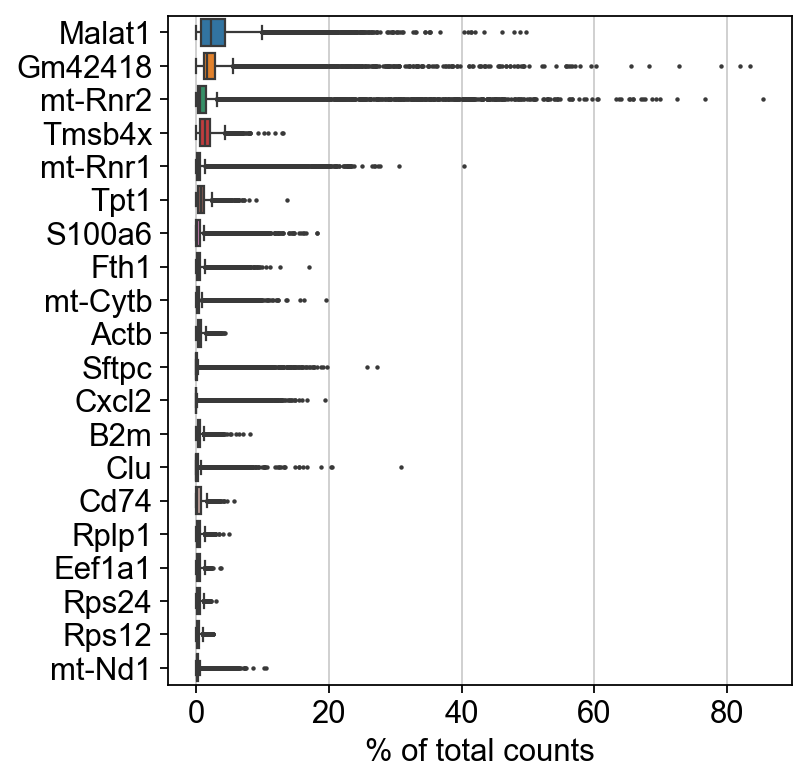

In [13]:
sc.pl.highest_expr_genes(adata, n_top=20, )

Basic filtering:

In [14]:
sc.pp.filter_cells(adata, min_counts=1500)
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 823 cells that have less than 1500 counts
filtered out 73 cells that have less than 300 genes expressed
filtered out 28131 genes that are detected in less than 3 cells


In [15]:
adata.var['mt'] = adata.var_names.str.startswith('mt-') # annotate the group of mitochondrial genes as 'MT'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

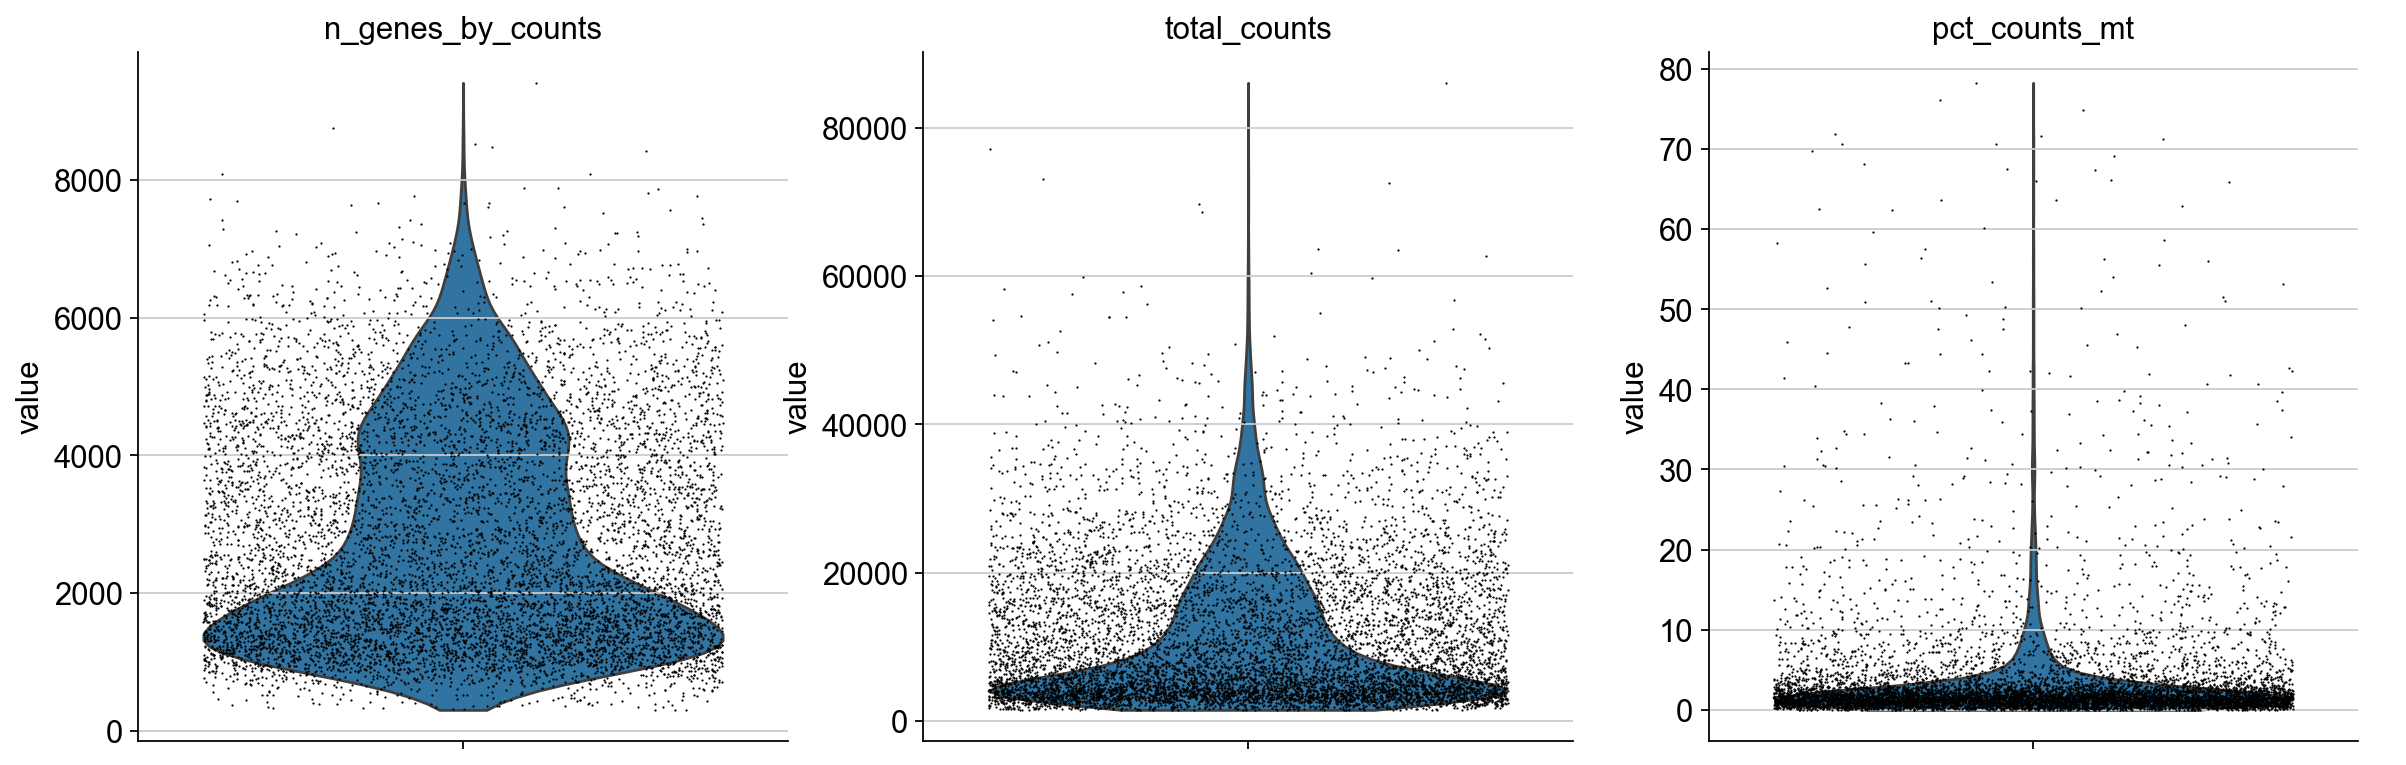

In [16]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True, rotation=90)

(array([   5.,   11.,   67.,  218.,  512., 1514., 2893., 2800.,  618.,
          36.]),
 array([0.68123135, 0.70865125, 0.73607115, 0.76349105, 0.79091096,
        0.81833086, 0.84575076, 0.87317066, 0.90059057, 0.92801047,
        0.95543037]),
 <BarContainer object of 10 artists>)

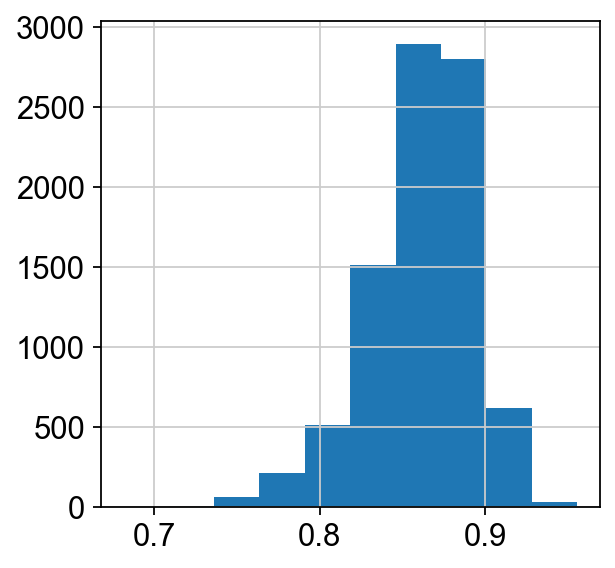

In [17]:
adata.obs["log10GenesPerUMI"] = adata.obs['n_genes_by_counts'].apply(math.log10) / adata.obs['total_counts'].apply(math.log10)
matplotlib.pyplot.hist(adata.obs["log10GenesPerUMI"])

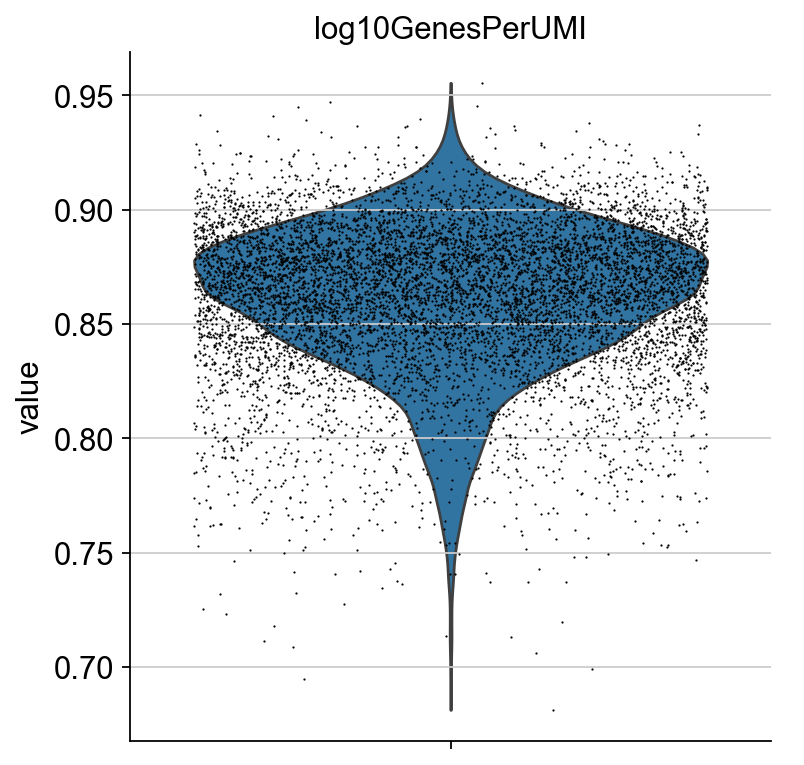

In [18]:
sc.pl.violin(adata, ['log10GenesPerUMI'],
             jitter=0.4, multi_panel=True, rotation=90)
#99% seems like a good Human pct count cutoff

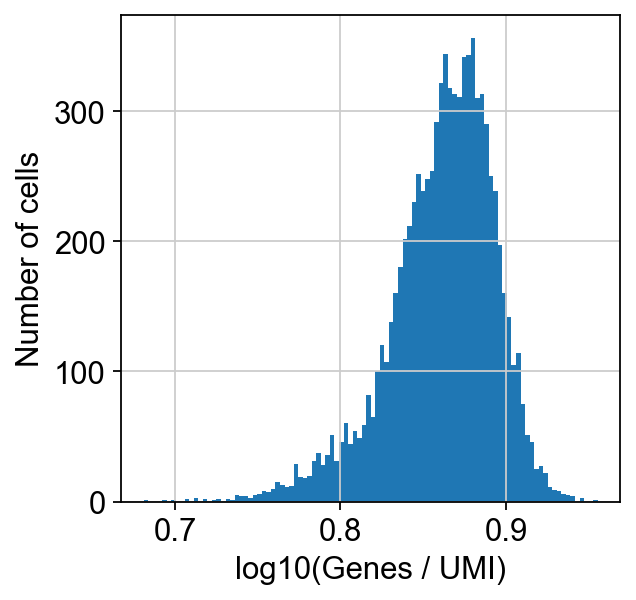

In [19]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(adata.obs["log10GenesPerUMI"], bins=100)
plt.xlabel("log10(Genes / UMI)")
plt.ylabel("Number of cells")
plt.show()


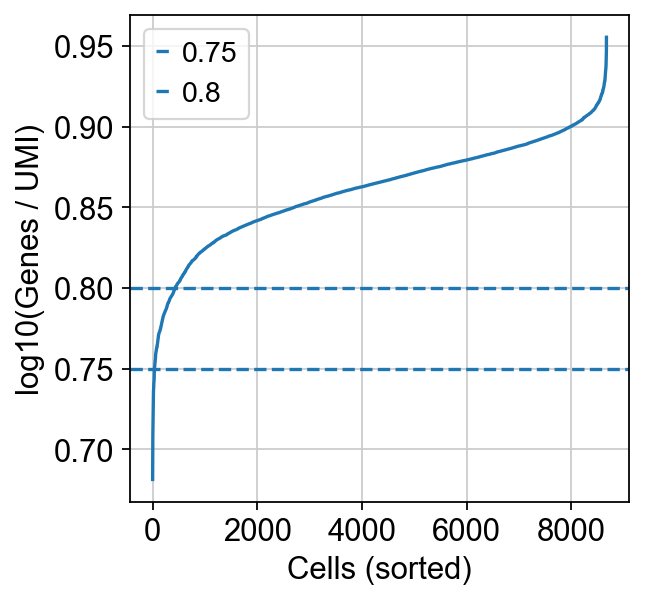

In [20]:
import numpy as np
import matplotlib.pyplot as plt

vals = np.sort(adata.obs["log10GenesPerUMI"].values)

plt.figure()
plt.plot(vals)
plt.xlabel("Cells (sorted)")
plt.ylabel("log10(Genes / UMI)")
plt.axhline(0.75, linestyle="--", label="0.75")
plt.axhline(0.8, linestyle="--", label="0.8")
plt.legend()
plt.show()


In [21]:
#Filter by Log10GenesPerUMI
adata = adata[adata.obs.log10GenesPerUMI >= 0.8,:]

In [22]:
#adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt <= 20, :]

## Run Demultiplexing

In [23]:
hashadata = hashadata[hashadata.obs.index.isin(adata.obs.index), :]

In [24]:
hashadata.var_names

Index(['BE1156_(BD1671)_B0301', 'BE1155_(BD1672)_B0302', 'BD1939_B0303',
       'BE1137_B0304', 'BE1157_(BD1674)_B0305', 'BD1941_B0306', 'BE1139_B0307',
       'BE1140-NT_B0308', 'BE1490_B0309', 'BE1491-NT_B0310', 'BE1662_B0311',
       'BF1240_(BE1834)_B0312', 'BF1087_B0313'],
      dtype='object')

In [25]:
hashCounts = pd.DataFrame(hashadata.X.todense(), columns=hashadata.var_names, index=adata.obs.index)

In [26]:
hashDisc = hashCounts.describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,0.99])
hashDisc

BE1156_(BD1671)_B0301  BE1155_(BD1672)_B0302  BD1939_B0303  \
count            8043.000000            8043.000000   8043.000000   
mean              194.810150             171.674133     63.669029   
std              1065.797729            1174.389893    559.442078   
min                 0.000000               0.000000      0.000000   
10%                 6.000000               8.000000      1.000000   
20%                 8.000000              10.000000      1.000000   
30%                 9.000000              12.000000      2.000000   
40%                11.000000              13.000000      3.000000   
50%                12.000000              14.000000      3.000000   
60%                13.000000              16.000000      4.000000   
70%                15.000000              18.000000      5.000000   
80%                18.000000              21.000000      6.000000   
90%                25.000000              26.000000      8.000000   
99%              5801.280000            6052.400000   2343.580000   
max             20453.000000           26815.000000  12296.000000   

       BE1137_B0304  BE1157_(BD1674)_B0305  BD1941_B0306  BE1139_B0307  \
count   8043.000000            8043.000000   8043.000000   8043.000000   
mean      12.613453              99.034317    168.007217     30.771851   
std      437.418213             496.304810    923.505798    393.445709   
min        0.000000               0.000000      0.000000      0.000000   
10%        0.000000               5.000000      6.000000      0.000000   
20%        0.000000               6.000000      7.000000      0.000000   
30%        0.000000               7.000000      8.000000      1.000000   
40%        0.000000               8.000000      9.000000      1.000000   
50%        0.000000               9.000000     11.000000      1.000000   
60%        0.000000              11.000000     12.000000      2.000000   
70%        1.000000              13.000000     14.000000      2.000000   
80%        1.000000              15.000000     16.000000      3.000000   
90%        2.000000              39.000000     22.000000      4.000000   
99%        7.000000            2274.640000   4796.820000    238.180000   
max    28724.000000           13418.000000  25866.000000  21514.000000   

       BE1140-NT_B0308  BE1490_B0309  BE1491-NT_B0310  BE1662_B0311  \
count      8043.000000   8043.000000      8043.000000   8043.000000   
mean        168.484772    425.793976        66.910851     28.677359   
std         935.578979   1704.965210       463.165985    309.176086   
min           0.000000      0.000000         0.000000      0.000000   
10%           8.000000     11.000000         0.000000      0.000000   
20%          10.000000     14.000000         1.000000      0.000000   
30%          11.000000     16.000000         1.000000      1.000000   
40%          12.000000     17.000000         2.000000      1.000000   
50%          14.000000     19.000000         2.000000      1.000000   
60%          15.000000     21.000000         3.000000      1.000000   
70%          18.000000     24.000000         4.000000      2.000000   
80%          20.000000     30.000000         5.000000      2.000000   
90%          28.000000    187.800000         7.000000      3.000000   
99%        5064.680000   8708.480000      1895.640000    954.300000   
max       19109.000000  27562.000000     17537.000000  14752.000000   

       BF1240_(BE1834)_B0312  BF1087_B0313  
count            8043.000000   8043.000000  
mean               21.218575    950.064392  
std               444.463257   1276.697144  
min                 0.000000      0.000000  
10%                 0.000000     18.000000  
20%                 0.000000     23.000000  
30%                 0.000000     31.000000  
40%                 0.000000    176.800000  
50%                 0.000000    747.000000  
60%                 1.000000   1056.200000  
70%                 1.000000   1317.000000  
80%                 1.000000   1660.0000

In [27]:
hashIDs = hashCounts.copy()
hashID = hashadata.var_names
for hashName in hashadata.var_names:
    print(hashName)
    print(hashDisc.loc["90%",hashName])
    hashIDs.loc[:,hashName] = hashCounts.loc[:,hashName] > hashDisc.loc["90%",hashName]
hashIDs

BE1156_(BD1671)_B0301
25.0
BE1155_(BD1672)_B0302
26.0
BD1939_B0303
8.0
BE1137_B0304
2.0
BE1157_(BD1674)_B0305
39.0
BD1941_B0306
22.0
BE1139_B0307
4.0
BE1140-NT_B0308
28.0
BE1490_B0309
187.80000000000018
BE1491-NT_B0310
7.0
BE1662_B0311
3.0
BF1240_(BE1834)_B0312
2.0
BF1087_B0313
2266.8


/tmp/ipykernel_4035621/2942643048.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ... False False False]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hashIDs.loc[:,hashName] = hashCounts.loc[:,hashName] > hashDisc.loc["90%",hashName]
/tmp/ipykernel_4035621/2942643048.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ... False False  True]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hashIDs.loc[:,hashName] = hashCounts.loc[:,hashName] > hashDisc.loc["90%",hashName]
/tmp/ipykernel_4035621/2942643048.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False  True ... False False False]' has dtype incompatible with float32, please exp

BE1156_(BD1671)_B0301  BE1155_(BD1672)_B0302  \
AAACCCAAGGACATCG-1                  False                  False   
AAACCCAAGGGTAGCT-1                  False                  False   
AAACCCAAGGTCCAGA-1                  False                  False   
AAACCCACATCTAACG-1                  False                  False   
AAACCCAGTCGCCTAG-1                  False                  False   
...                                   ...                    ...   
TTTGTTGGTCCAAATC-1                  False                  False   
TTTGTTGTCACCATCC-1                  False                  False   
TTTGTTGTCATGCCCT-1                  False                  False   
TTTGTTGTCTATCACT-1                  False                  False   
TTTGTTGTCTCGACCT-1                  False                   True   

                    BD1939_B0303  BE1137_B0304  BE1157_(BD1674)_B0305  \
AAACCCAAGGACATCG-1         False         False                  False   
AAACCCAAGGGTAGCT-1         False         False                  False   
AAACCCAAGGTCCAGA-1          True         False                  False   
AAACCCACATCTAACG-1         False         False                  False   
AAACCCAGTCGCCTAG-1         False         False                  False   
...                          ...           ...                    ...   
TTTGTTGGTCCAAATC-1         False         False                   True   
TTTGTTGTCACCATCC-1         False         False                  False   
TTTGTTGTCATGCCCT-1         False         False                  False   
TTTGTTGTCTATCACT-1         False         False                  False   
TTTGTTGTCTCGACCT-1         False         False                  False   

                    BD1941_B0306  BE1139_B0307  BE1140-NT_B0308  BE1490_B0309  \
AAACCCAAGGACATCG-1         False         False            False         False   
AAACCCAAGGGTAGCT-1         False         False            False         False   
AAACCCAAGGTCCAGA-1         False         False            False         False   
AAACCCACATCTAACG-1         False         False            False          True   
AAACCCAGTCGCCTAG-1         False         False            False          True   
...                          ...           ...              ...           ...   
TTTGTTGGTCCAAATC-1         False         False            False         False   
TTTGTTGTCACCATCC-1         False         False            False         False   
TTTGTTGTCATGCCCT-1         False          True            False         False   
TTTGTTGTCTATCACT-1         False         False            False          True   
TTTGTTGTCTCGACCT-1         False          True            False         False   

                    BE1491-NT_B0310  BE1662_B0311  BF1240_(BE1834)_B0312  \
AAACCCAAGGACATCG-1            False         False                  False   
AAACCCAAGGGTAGCT-1            False         False                   True   
AAACCCAAGGTCCAGA-1            False         False                   True   
AAACCCACATCTAACG-1            False         False                  False   
AAACCCAGTCGCCTAG-1            False         False                  False   
...                             ...           ...                    ...   
TTTGTTGGTCCAAATC-1            False         False                  False   
TTTGTTGTCACCATCC-1            False          True                  False   
TTTGTTGTCATGCCCT-1            False         False                  False   
TTTGTTGTCTATCACT-1            False         False                  False   
TTTGTTGTCTCGACCT-1            False         False                  False   

                    BF1087_B0313  
AAACCCAAGGACATCG-1         False  
AAACCCAAGGGTAGCT-1         False  
AAACCCAAGGTCCAGA-1          True  
AAACCCACATCTAACG-1         False  
AAACCCAGTCGCCTAG-1         False  
...                          ...  
TTTGTTGGTCCAAATC-1         False  
TTTGTTGTCACCATCC-1         False  
TTTGTTGTCATGCCCT-1         False  
TTTGTTGTCTATCACT-1         False  
TTTGTTGTCTCGACCT-1         False  

[8043 rows x 13 col

In [28]:
from matplotlib import pyplot as plt

In [29]:
hashCounts

BE1156_(BD1671)_B0301  BE1155_(BD1672)_B0302  \
AAACCCAAGGACATCG-1                   10.0                   18.0   
AAACCCAAGGGTAGCT-1                   10.0                   23.0   
AAACCCAAGGTCCAGA-1                   17.0                    9.0   
AAACCCACATCTAACG-1                   10.0                   12.0   
AAACCCAGTCGCCTAG-1                   22.0                   18.0   
...                                   ...                    ...   
TTTGTTGGTCCAAATC-1                   12.0                   16.0   
TTTGTTGTCACCATCC-1                   15.0                   10.0   
TTTGTTGTCATGCCCT-1                   21.0                   20.0   
TTTGTTGTCTATCACT-1                   10.0                   11.0   
TTTGTTGTCTCGACCT-1                   13.0                  259.0   

                    BD1939_B0303  BE1137_B0304  BE1157_(BD1674)_B0305  \
AAACCCAAGGACATCG-1           3.0           0.0                   10.0   
AAACCCAAGGGTAGCT-1           3.0           0.0                   11.0   
AAACCCAAGGTCCAGA-1          31.0           0.0                    8.0   
AAACCCACATCTAACG-1           3.0           0.0                    6.0   
AAACCCAGTCGCCTAG-1           4.0           0.0                   20.0   
...                          ...           ...                    ...   
TTTGTTGGTCCAAATC-1           2.0           0.0                  325.0   
TTTGTTGTCACCATCC-1           1.0           0.0                    8.0   
TTTGTTGTCATGCCCT-1           5.0           0.0                   11.0   
TTTGTTGTCTATCACT-1           2.0           0.0                    7.0   
TTTGTTGTCTCGACCT-1           3.0           0.0                    7.0   

                    BD1941_B0306  BE1139_B0307  BE1140-NT_B0308  BE1490_B0309  \
AAACCCAAGGACATCG-1          13.0           0.0             15.0          18.0   
AAACCCAAGGGTAGCT-1          22.0           1.0             15.0          21.0   
AAACCCAAGGTCCAGA-1          13.0           4.0             20.0          27.0   
AAACCCACATCTAACG-1          15.0           0.0              8.0        2989.0   
AAACCCAGTCGCCTAG-1           9.0           2.0             17.0         192.0   
...                          ...           ...              ...           ...   
TTTGTTGGTCCAAATC-1           9.0           2.0             17.0          22.0   
TTTGTTGTCACCATCC-1          16.0           2.0             11.0          15.0   
TTTGTTGTCATGCCCT-1           8.0           6.0             10.0          15.0   
TTTGTTGTCTATCACT-1          11.0           0.0             12.0        2288.0   
TTTGTTGTCTCGACCT-1           8.0           5.0             10.0          10.0   

                    BE1491-NT_B0310  BE1662_B0311  BF1240_(BE1834)_B0312  \
AAACCCAAGGACATCG-1              1.0           3.0                    0.0   
AAACCCAAGGGTAGCT-1              4.0           1.0                    3.0   
AAACCCAAGGTCCAGA-1              2.0           3.0                    3.0   
AAACCCACATCTAACG-1              3.0           1.0                    2.0   
AAACCCAGTCGCCTAG-1              1.0           0.0                    0.0   
...                             ...           ...                    ...   
TTTGTTGGTCCAAATC-1              1.0           2.0                    2.0   
TTTGTTGTCACCATCC-1              1.0           4.0                    2.0   
TTTGTTGTCATGCCCT-1              0.0           2.0                    0.0   
TTTGTTGTCTATCACT-1              2.0           3.0                    1.0   
TTTGTTGTCTCGACCT-1              5.0           1.0                    0.0   

                    BF1087_B0313  
AAACCCAAGGACATCG-1        1783.0  
AAACCCAAGGGTAGCT-1         800.0  
AAACCCAAGGTCCAGA-1        2311.0  
AAACCCACATCTAACG-1        1731.0  
AAACCCAGTCGCCTAG-1         470.0  
...                          ...  
TTTGTTGGTCCAAATC-1          18.0  
TTTGTTGTCACCATCC-1         705.0  
TTTGTTGTCATGCCCT-1        1989.0  
TTTGTTGTCTATCACT-1          17.0  
TTTGTTGTCTCGACCT-1        1114.0  

[8043 rows x 13 col

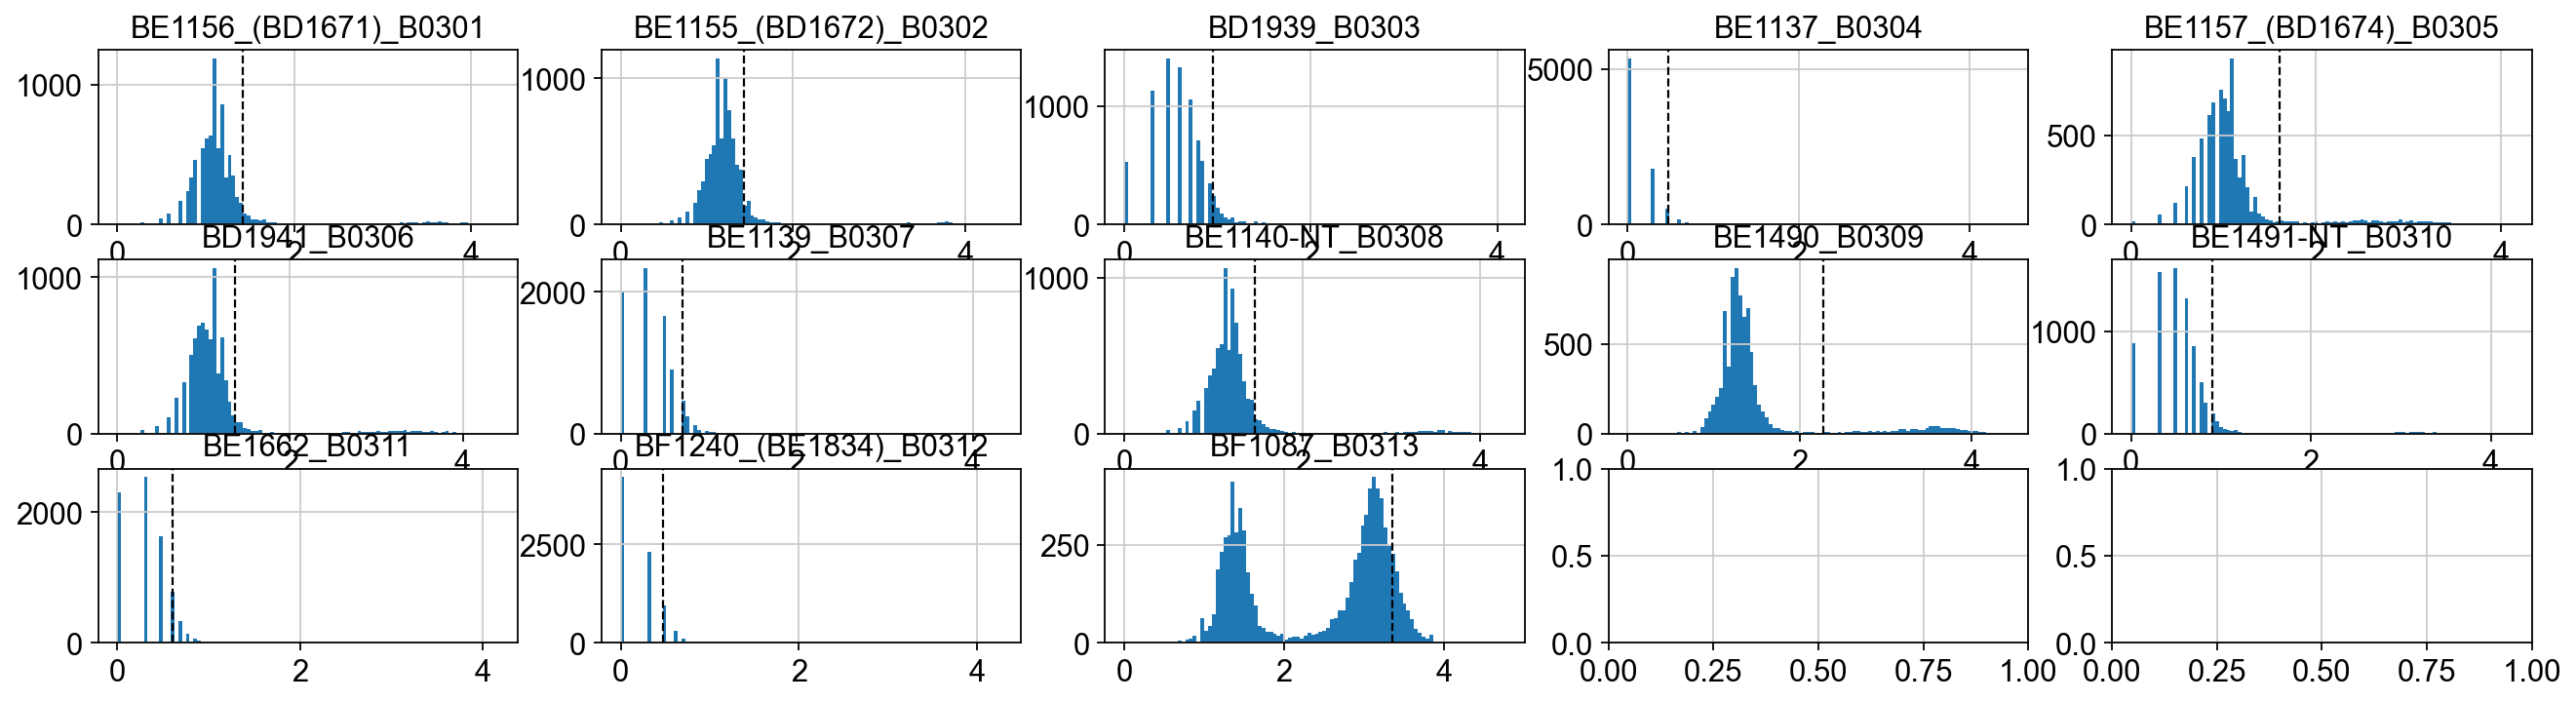

In [30]:
fig, axs = plt.subplots(3,5, figsize =(20, 5))

for i, hashName in enumerate(hashadata.var_names):
    hashCounts2 = np.log10(hashCounts[hashName]+1)
    axs[i//5,i%5].set_title(hashName)
    axs[i//5,i%5].hist(hashCounts2, bins = 100)
    axs[i//5,i%5].axvline(np.log10(int(hashDisc.loc["90%",hashName])+1), color='k', linestyle='dashed', linewidth=1)

#plt.rcParams["figure.figsize"] = (20,5)
plt.show()

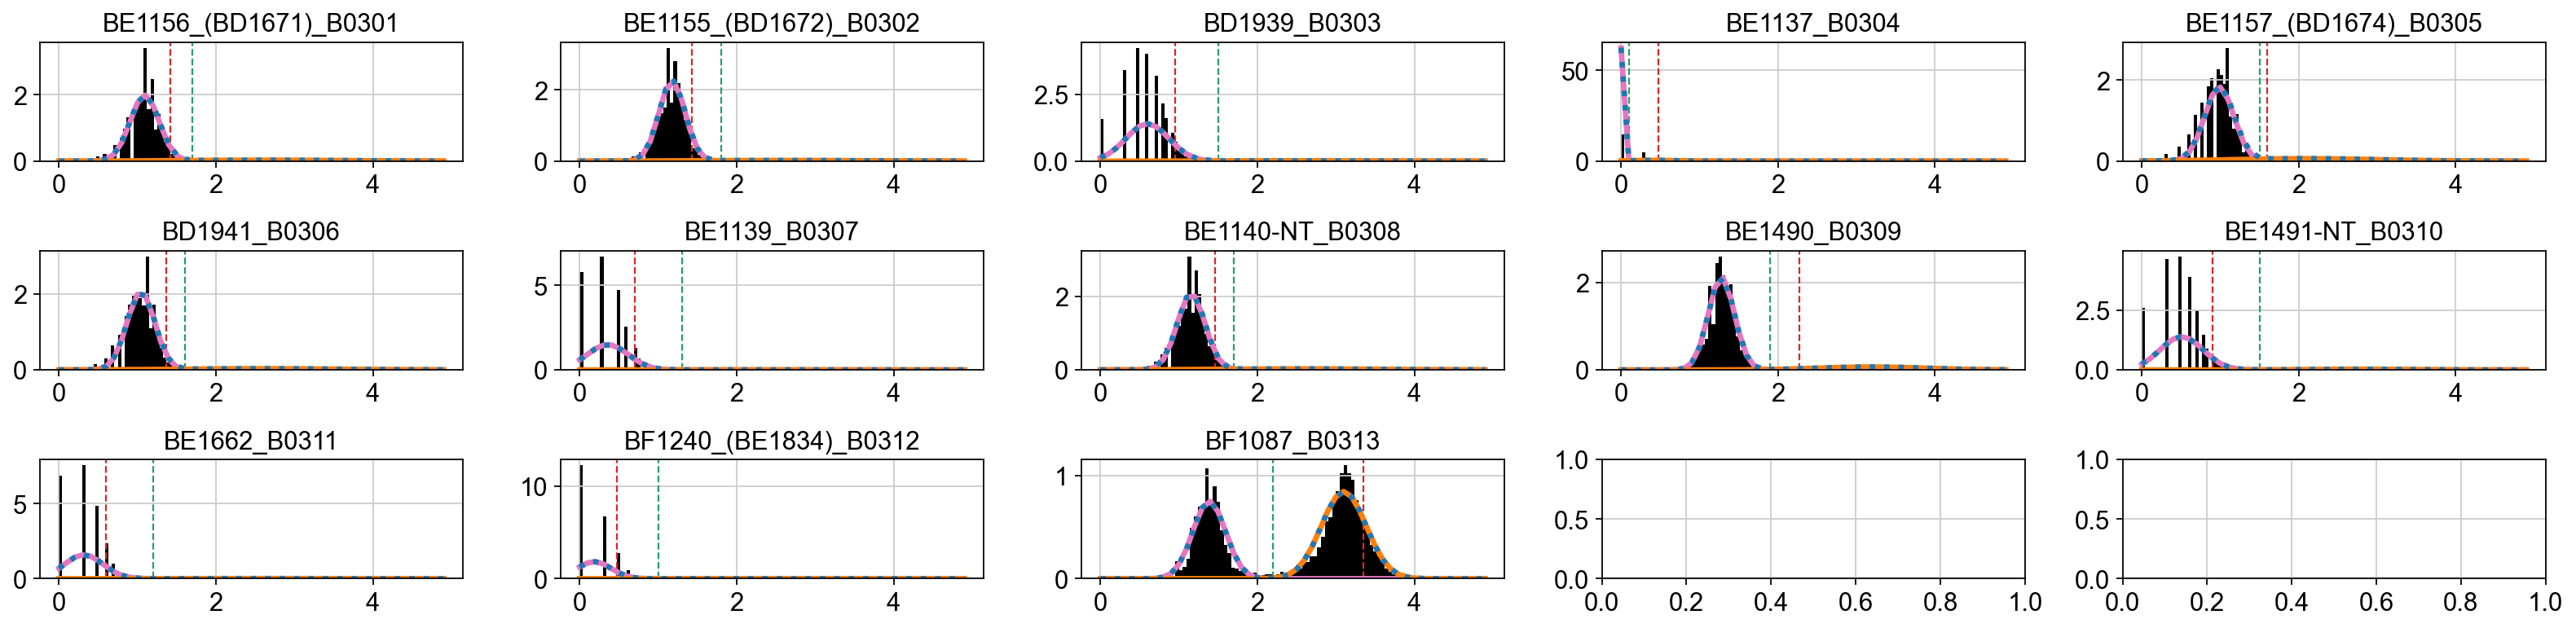

In [31]:
from sklearn.mixture import BayesianGaussianMixture
from scipy.stats import norm
fig, axs = plt.subplots(3,5, figsize =(20, 5))
dfHashBoundry = pd.DataFrame(np.zeros(len(hashadata.var_names)),hashadata.var_names, columns=["boundry"])
gmm = BayesianGaussianMixture(n_components=2, random_state=250,init_params='k-means++')
binEx = np.arange(0,5,5/100).reshape(-1,1)

for i, hashName in enumerate(hashadata.var_names):
    hashCount = np.array(np.log10(hashCounts[hashName]+1)).reshape(-1, 1)
    fitGMM = gmm.fit(hashCount)
    mean = fitGMM.means_  
    covs  = fitGMM.covariances_
    weights = fitGMM.weights_
  
    fitGmmBound = fitGMM.predict(binEx)

    if mean[0][0] < mean[1][0]:
        left_idx, right_idx = 0, 1
    else:
        left_idx, right_idx = 1, 0

    
    x_axis = np.arange(0, 5, 0.1)
    
    y_left = norm.pdf(x_axis, float(mean[left_idx][0]), np.sqrt(float(covs[left_idx][0][0]))) * weights[left_idx]
    y_right = norm.pdf(x_axis, float(mean[right_idx][0]), np.sqrt(float(covs[right_idx][0][0]))) * weights[right_idx]

    hashBoundry = False #binEx[np.where(fitGmmBound == 1)[0][0]][0]  

    diff = y_right - y_left
    crossings = np.where(np.diff(np.sign(diff)) > 0)[0]  # where right overtakes left
    
    if len(crossings) > 0:
        # Take the first crossing where right becomes dominant
        idx = crossings[0]
        hashBoundry = x_axis[idx + 1]  # slightly to the right
    else:
        # If no intersection found, fall back to right mean or a fixed value
        hashBoundry = float(mean[right_idx][0])

    
    naiveBoundry = np.log10(int(hashDisc.loc["90%",hashName])+1)
    
    dfHashBoundry.loc[hashName] = hashBoundry
    
    # Plot 2
    axs[i//5,i%5].set_title(hashName)
    axs[i//5,i%5].axvline(naiveBoundry, c='C3', linestyle='dashed', linewidth=1) #red
    axs[i//5,i%5].axvline(hashBoundry, c='C2', linestyle='dashed', linewidth=1)  #green
    axs[i//5,i%5].hist(hashCount, density=True, color='black', bins=100)        
    axs[i//5,i%5].plot(x_axis, y_left, lw=3, c='C6')                            #pink
    axs[i//5,i%5].plot(x_axis, y_right, lw=3, c='C1')                            #orange
    axs[i//5,i%5].plot(x_axis, y_left+y_right, lw=3, c='C0', ls=':')            #dotted blue
    
plt.tight_layout(pad=1.0)
#plt.rcParams["figure.figsize"] = (20,5)
plt.show()

In [32]:
hashIDs = hashCounts.copy()
hashID = hashadata.var_names
#set manual minimum threshold to be 1
for hashName in hashadata.var_names:
    print(hashName)
    print(dfHashBoundry.loc[hashName].values[0])
    #manually set minimum threshold to 1 given poor HashData
    if (dfHashBoundry.loc[hashName].values[0] < 1):
        dfHashBoundry.loc[hashName].values[0] = 1
    print(dfHashBoundry.loc[hashName].values[0])
    hashIDs.loc[:,hashName] = np.log10(hashCounts.loc[:,hashName]+1) > dfHashBoundry.loc[hashName].values[0]
#hashIDs

BE1156_(BD1671)_B0301
1.7000000000000002
1.7000000000000002
BE1155_(BD1672)_B0302
1.8
1.8
BD1939_B0303
1.5
1.5
BE1137_B0304
0.1
1.0
BE1157_(BD1674)_B0305
1.5
1.5
BD1941_B0306
1.6
1.6
BE1139_B0307
1.3
1.3
BE1140-NT_B0308
1.7000000000000002
1.7000000000000002
BE1490_B0309
1.9000000000000001
1.9000000000000001
BE1491-NT_B0310
1.5
1.5
BE1662_B0311
1.2000000000000002
1.2000000000000002
BF1240_(BE1834)_B0312
1.0
1.0
BF1087_B0313
2.2
2.2


/tmp/ipykernel_4035621/4060069450.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ... False False False]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hashIDs.loc[:,hashName] = np.log10(hashCounts.loc[:,hashName]+1) > dfHashBoundry.loc[hashName].values[0]
/tmp/ipykernel_4035621/4060069450.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ... False False  True]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hashIDs.loc[:,hashName] = np.log10(hashCounts.loc[:,hashName]+1) > dfHashBoundry.loc[hashName].values[0]
/tmp/ipykernel_4035621/4060069450.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False  True ... False False False]' ha

In [33]:
classification = np.empty(len(adata), dtype="object")
i = 0
for cellBar, hashBool in hashIDs.iterrows():
    numHashes = sum(hashBool)
    if (numHashes == 1):
        classif = hashID[hashBool.values].values[0]
    elif (numHashes > 1):
        classif = "doublet"
    else:
        classif = "negative"
    classification[i] = classif
    i = i + 1
    #break

In [34]:
adata.obs["Classification"] = classification
hashadata.obs["Classification"] = classification
adata.obs["Classification"].value_counts()

/tmp/ipykernel_4035621/4135005838.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["Classification"] = classification
/tmp/ipykernel_4035621/4135005838.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  hashadata.obs["Classification"] = classification


Classification
BF1087_B0313             3855
doublet                  1309
BE1490_B0309              622
BE1157_(BD1674)_B0305     546
BD1941_B0306              325
BE1156_(BD1671)_B0301     266
BE1140-NT_B0308           257
BE1491-NT_B0310           242
negative                  205
BE1155_(BD1672)_B0302     164
BD1939_B0303               87
BE1662_B0311               84
BE1139_B0307               55
BF1240_(BE1834)_B0312      21
BE1137_B0304                5
Name: count, dtype: int64

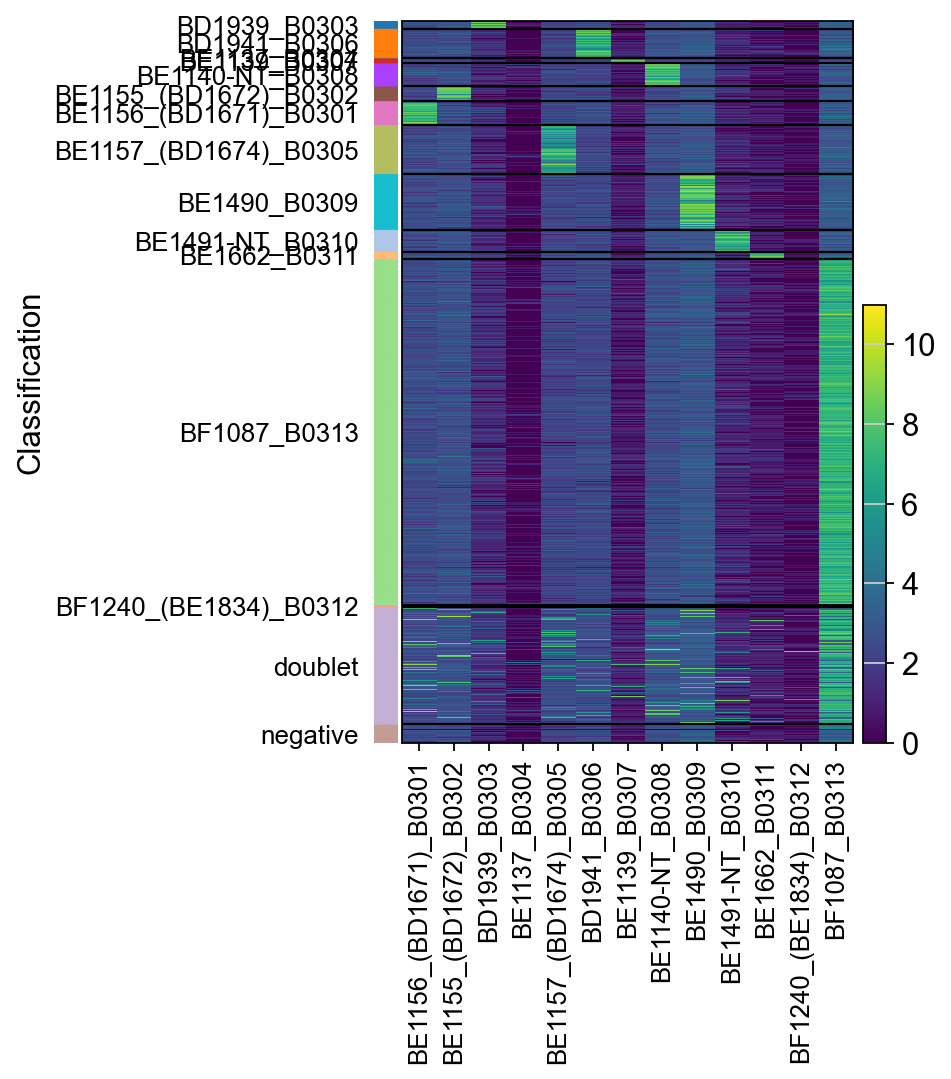

In [35]:
#output visulaization of hashing
sc.pl.heatmap(hashadata, hashadata.var_names, groupby="Classification", log=True)#, save = f"_{figName}_hash.png")

## set transgenes

(array([7.97e+03, 3.60e+01, 1.90e+01, 1.00e+01, 4.00e+00, 1.00e+00,
        2.00e+00, 0.00e+00, 0.00e+00, 1.00e+00]),
 array([  0.        ,  10.80000019,  21.60000038,  32.40000153,
         43.20000076,  54.        ,  64.80000305,  75.59999847,
         86.40000153,  97.20000458, 108.        ]),
 <BarContainer object of 10 artists>)

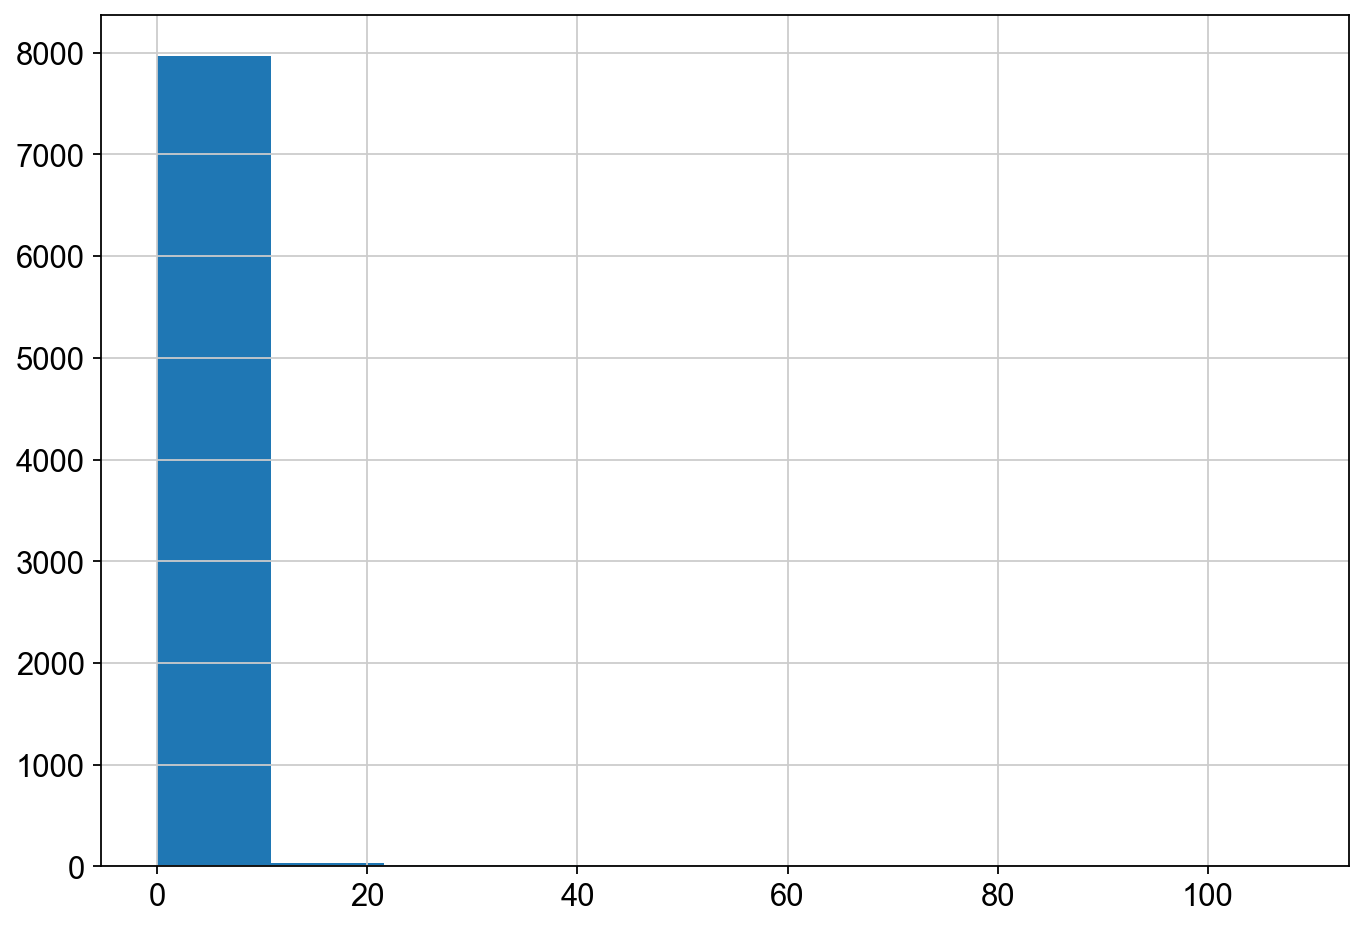

In [36]:
#Remove any cell with PTPRC counts
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(adata.X[:,adata.var.index.isin(['shRenilla'])].toarray())
#ax.axvline(np.log10(int(hashDisc.loc["90%",hashName])+1), color='k', linestyle='dashed', linewidth=1)
# Show plot
#adata.obs['shRen'] = 0

#adata.obs['shRenilla'][adata.X[:,adata.var.index.isin(['shRenilla'])] >0] #= adata.X[:,adata.var.index.isin(['shRenilla'])]

In [37]:
adata.obs['shRen'] = adata.X[:,adata.var.index.isin(['shRenilla'])].toarray()

(array([7.989e+03, 3.300e+01, 1.100e+01, 6.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([  0.        ,  15.69999981,  31.39999962,  47.09999847,
         62.79999924,  78.5       ,  94.19999695, 109.90000153,
        125.59999847, 141.30000305, 157.        ]),
 <BarContainer object of 10 artists>)

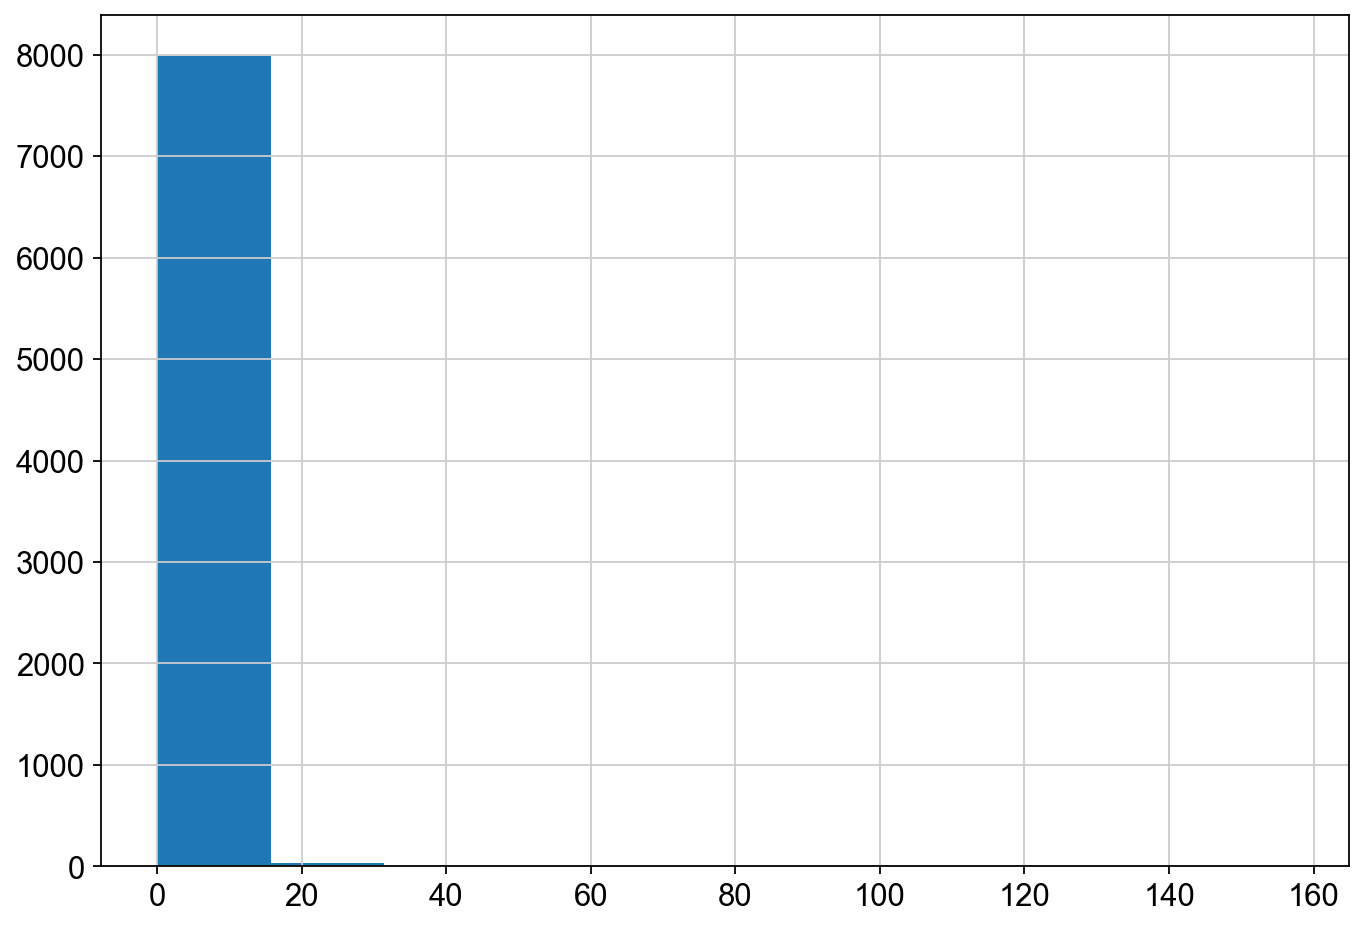

In [38]:
#Remove any cell with PTPRC counts
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(adata.X[:,adata.var.index.isin(['2118-Nfkb1.3737'])].toarray())
#ax.axvline(np.log10(int(hashDisc.loc["90%",hashName])+1), color='k', linestyle='dashed', linewidth=1)
# Show plot
#adata.obs['2118-Nfkb1.3737'] = 0

#adata.obs['shRenilla'][adata.X[:,adata.var.index.isin(['shRenilla'])] >0] #= adata.X[:,adata.var.index.isin(['shRenilla'])]

In [39]:
adata.obs['2118-Nfkb1'] = adata.X[:,adata.var.index.isin(['2118-Nfkb1.3737'])].toarray()

(array([7.976e+03, 4.400e+01, 1.300e+01, 6.000e+00, 3.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([  0. ,  12.5,  25. ,  37.5,  50. ,  62.5,  75. ,  87.5, 100. ,
        112.5, 125. ]),
 <BarContainer object of 10 artists>)

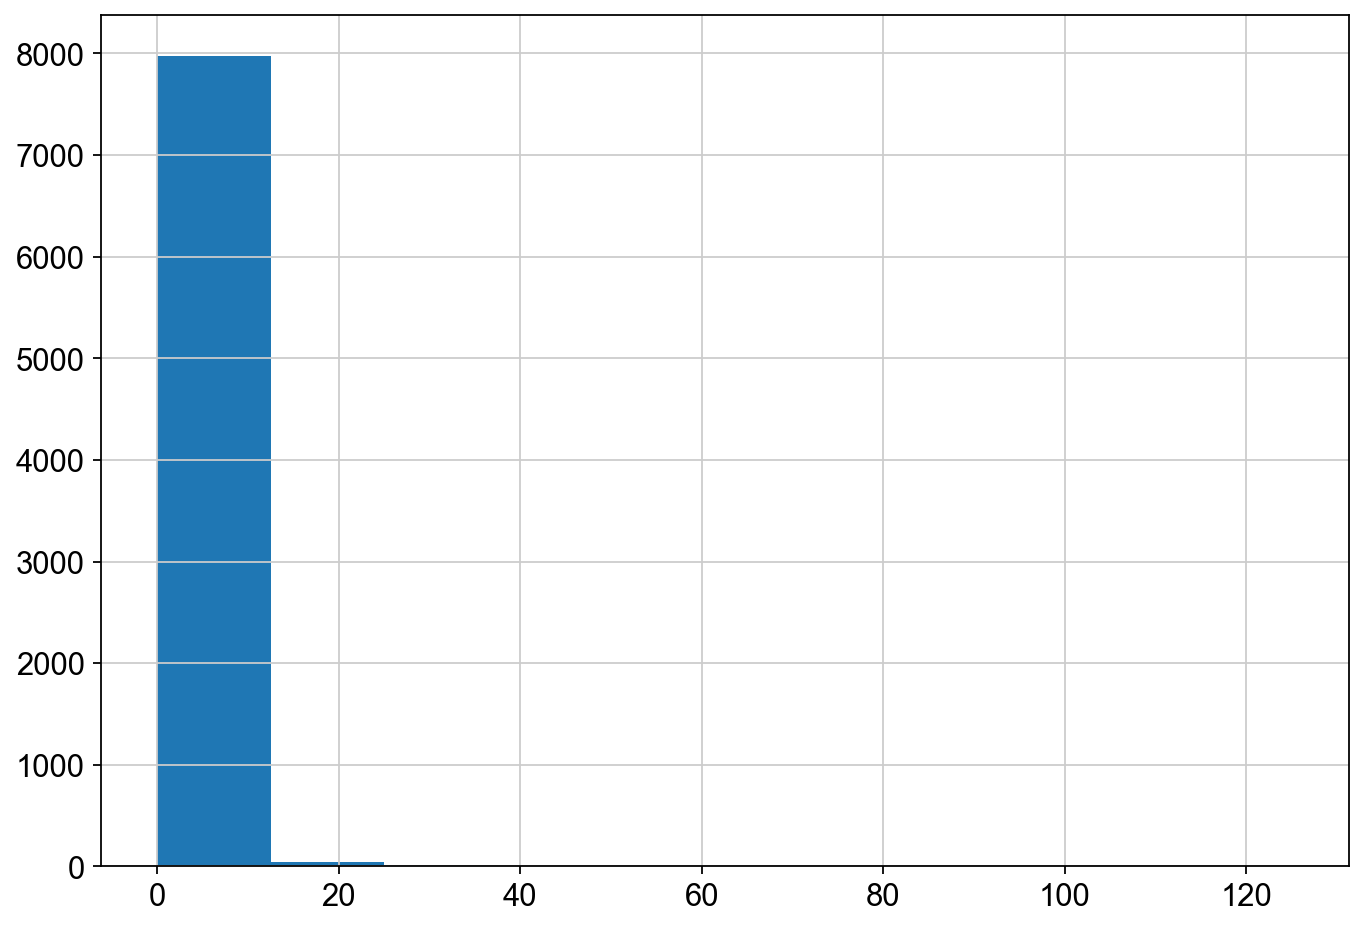

In [40]:
#Remove any cell with PTPRC counts
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(adata.X[:,adata.var.index.isin(['JCP621-shRela-4.1182'])].toarray())
#ax.axvline(np.log10(int(hashDisc.loc["90%",hashName])+1), color='k', linestyle='dashed', linewidth=1)
# Show plot
#adata.obs['2118-Nfkb1.3737'] = 0

#adata.obs['shRenilla'][adata.X[:,adata.var.index.isin(['shRenilla'])] >0] #= adata.X[:,adata.var.index.isin(['shRenilla'])]

In [41]:
adata.obs['shRela'] = adata.X[:,adata.var.index.isin(['JCP621-shRela-4.1182'])].toarray()

(array([7.932e+03, 4.600e+01, 3.500e+01, 1.300e+01, 5.000e+00, 3.000e+00,
        2.000e+00, 4.000e+00, 2.000e+00, 1.000e+00]),
 array([  0.        ,  13.80000019,  27.60000038,  41.40000153,
         55.20000076,  69.        ,  82.80000305,  96.59999847,
        110.40000153, 124.20000458, 138.        ]),
 <BarContainer object of 10 artists>)

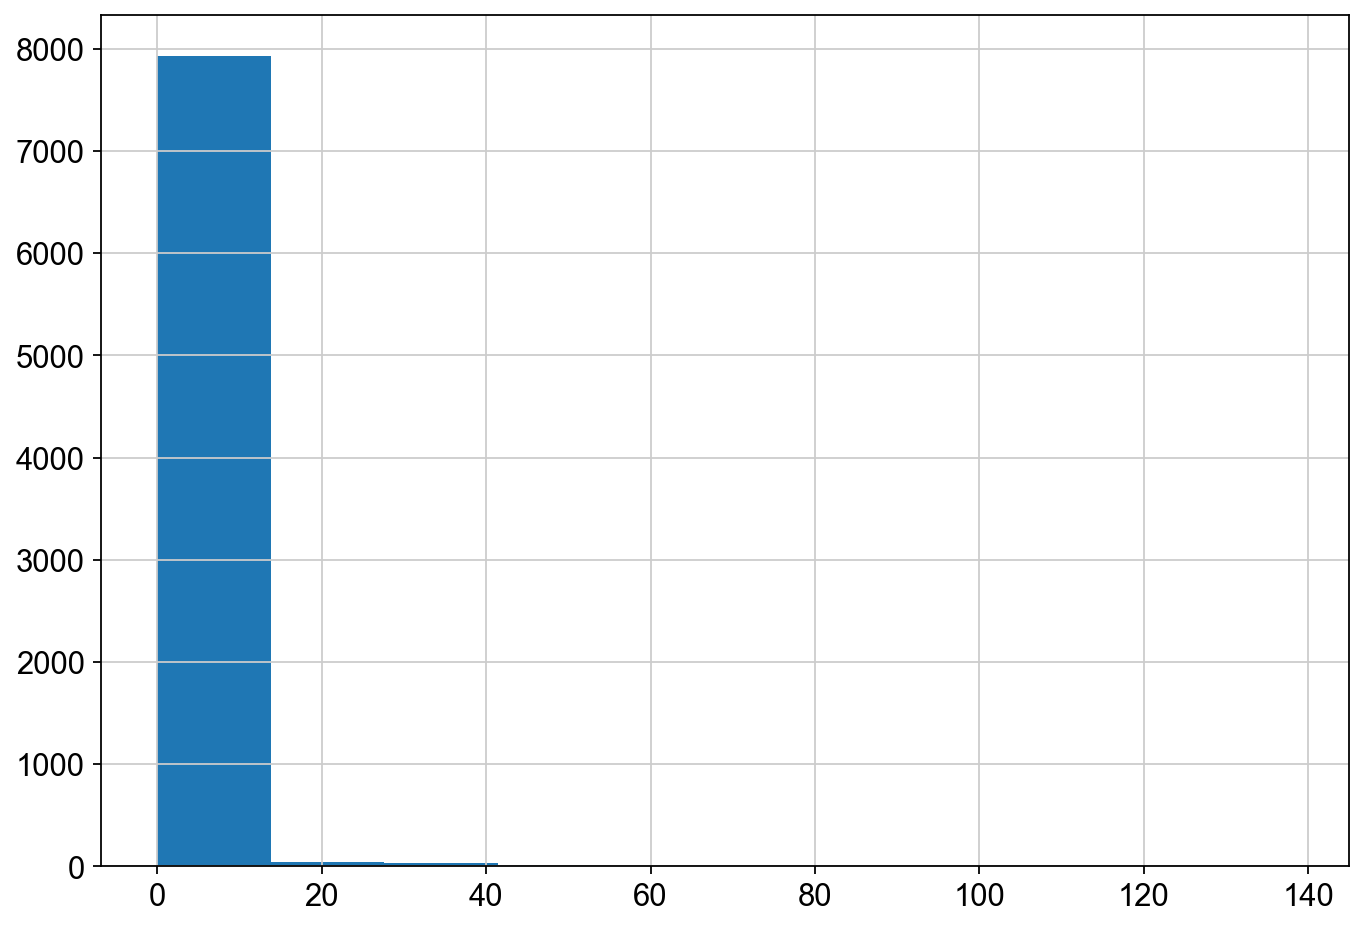

In [42]:
#Remove any cell with PTPRC counts
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(adata.X[:,adata.var.index.isin(['JCP625-shRel-3.342'])].toarray())
#ax.axvline(np.log10(int(hashDisc.loc["90%",hashName])+1), color='k', linestyle='dashed', linewidth=1)
# Show plot
#adata.obs['2118-Nfkb1.3737'] = 0

#adata.obs['shRenilla'][adata.X[:,adata.var.index.isin(['shRenilla'])] >0] #= adata.X[:,adata.var.index.isin(['shRenilla'])]

In [43]:
adata.obs['shRel'] = adata.X[:,adata.var.index.isin(['JCP625-shRel-3.342'])].toarray()

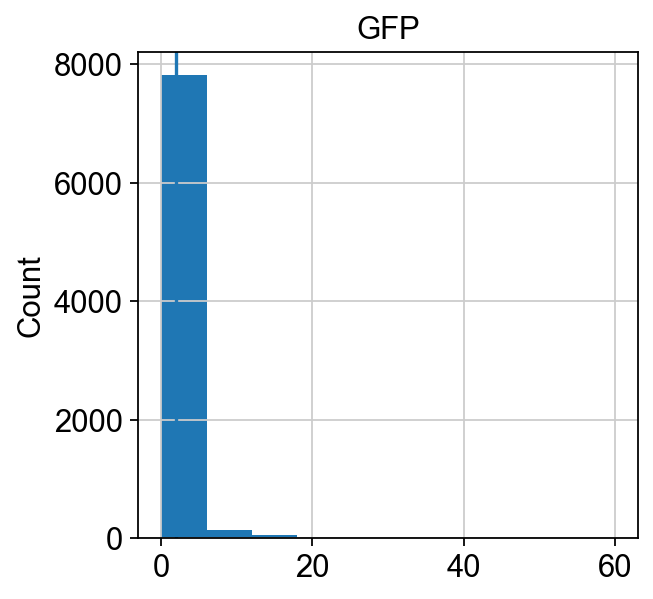

In [44]:
import matplotlib.pyplot as plt
adata.var.index.isin(['GFP'])
_ = plt.hist(adata[adata.obs.index,'GFP'].X.toarray())
plt.ylabel("Count")
plt.title("GFP")
plt.axvline(x=2)
plt.show()

In [45]:
adata.obs['GFP_count'] = adata.X[:,adata.var.index.isin(['GFP'])].toarray()

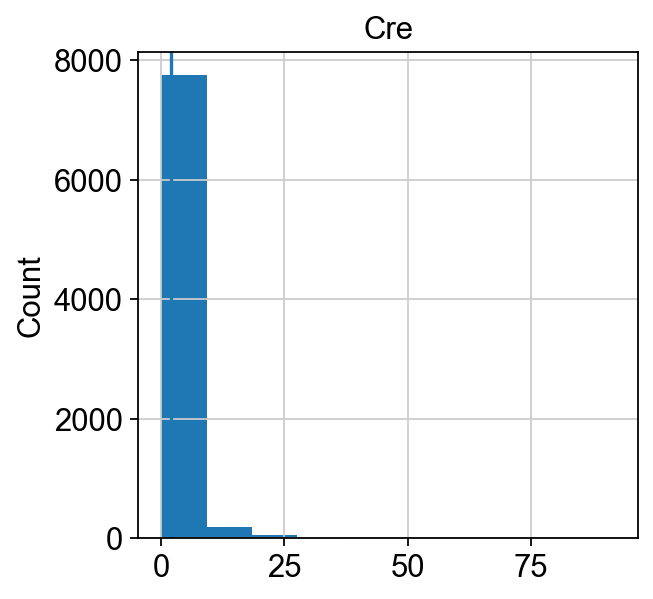

In [46]:
import matplotlib.pyplot as plt
adata.var.index.isin(['GFP'])
_ = plt.hist(adata[adata.obs.index,'Cre'].X.toarray())
plt.ylabel("Count")
plt.title("Cre")
plt.axvline(x=2)
plt.show()

In [47]:
adata.obs['Cre_count'] = adata.X[:,adata.var.index.isin(['Cre'])].toarray()

## Filter doublets and negative cells

In [48]:
adata.obs.Classification.value_counts()

Classification
BF1087_B0313             3855
doublet                  1309
BE1490_B0309              622
BE1157_(BD1674)_B0305     546
BD1941_B0306              325
BE1156_(BD1671)_B0301     266
BE1140-NT_B0308           257
BE1491-NT_B0310           242
negative                  205
BE1155_(BD1672)_B0302     164
BD1939_B0303               87
BE1662_B0311               84
BE1139_B0307               55
BF1240_(BE1834)_B0312      21
BE1137_B0304                5
Name: count, dtype: int64

In [49]:
adata = adata[~adata.obs['Classification'].isin(['doublet','negative']),:]

In [50]:
adata.obs.Classification.value_counts()

Classification
BF1087_B0313             3855
BE1490_B0309              622
BE1157_(BD1674)_B0305     546
BD1941_B0306              325
BE1156_(BD1671)_B0301     266
BE1140-NT_B0308           257
BE1491-NT_B0310           242
BE1155_(BD1672)_B0302     164
BD1939_B0303               87
BE1662_B0311               84
BE1139_B0307               55
BF1240_(BE1834)_B0312      21
BE1137_B0304                5
Name: count, dtype: int64

## Set Groups

In [51]:
samples

['BE1156_(BD1671)_B0301',
 'BE1155_(BD1672)_B0302',
 'BD1939_B0303',
 'BE1137_B0304',
 'BE1157_(BD1674)_B0305',
 'BD1941_B0306',
 'BE1139_B0307',
 'BE1140-NT_B0308',
 'BE1490_B0309',
 'BE1491-NT_B0310',
 'BE1662_B0311',
 'BF1240_(BE1834)_B0312',
 'BF1087_B0313']

In [52]:
#Set shRNA groups
adata.obs['shRNA'] = None
adata.obs['shRNA'][adata[adata.obs['shRen'] >= 2,:].obs.index] = 'shRenilla'
adata.obs['shRNA'][adata[adata.obs['2118-Nfkb1'] >= 2,:].obs.index] = '2118'
adata.obs['shRNA'][adata[adata.obs['shRel'] >= 2,:].obs.index] = 'shRel'
adata.obs['shRNA'][adata[adata.obs['shRela'] >= 2,:].obs.index] = 'shRela'

/tmp/ipykernel_4035621/74134016.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['shRNA'] = None
/tmp/ipykernel_4035621/74134016.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

In [53]:
samples

['BE1156_(BD1671)_B0301',
 'BE1155_(BD1672)_B0302',
 'BD1939_B0303',
 'BE1137_B0304',
 'BE1157_(BD1674)_B0305',
 'BD1941_B0306',
 'BE1139_B0307',
 'BE1140-NT_B0308',
 'BE1490_B0309',
 'BE1491-NT_B0310',
 'BE1662_B0311',
 'BF1240_(BE1834)_B0312',
 'BF1087_B0313']

In [54]:
#Set shRNA groups
adata.obs['Group'] = 'shNfkb1'
adata.obs['Group'][adata.obs.Classification.isin(['BF1240_(BE1834)_B0312','BF1087_B0313'])] = 'shRenilla'
adata.obs['Group'][adata.obs.Classification.isin(['BE1157_(BD1674)_B0305','BD1941_B0306','BE1139_B0307','BE1140-NT_B0308'])] = 'shRela'
adata.obs['Group'][adata.obs.Classification.isin(['BE1490_B0309','BE1491-NT_B0310','BE1662_B0311'])] = 'shRel'

/tmp/ipykernel_4035621/3992414676.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.obs['Group'][adata.obs.Classification.isin(['BF1240_(BE1834)_B0312','BF1087_B0313'])] = 'shRenilla'
/tmp/ipykernel_4035621/3992414676.py:3: SettingWi

## Double check shRNAs and filter accordingly

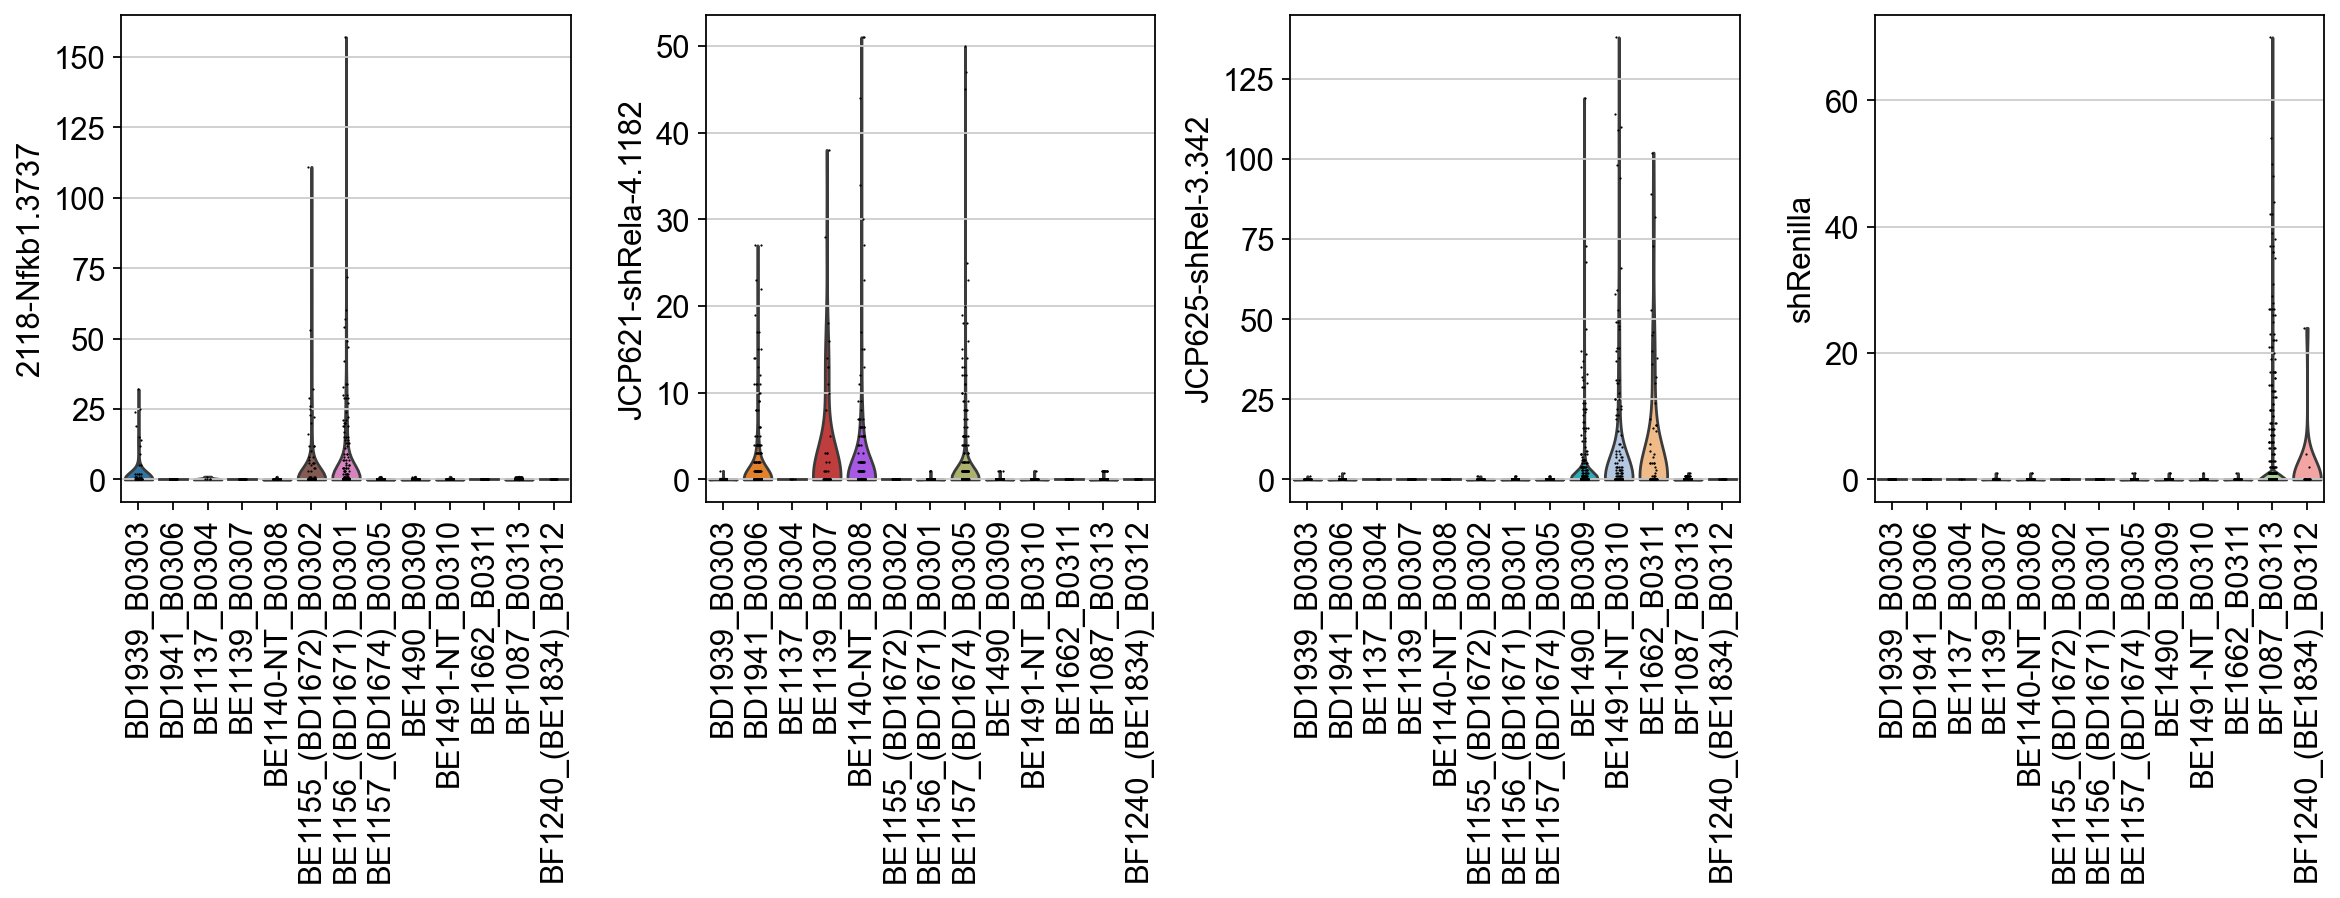

In [55]:
sc.pl.violin(adata,['2118-Nfkb1.3737','JCP621-shRela-4.1182','JCP625-shRel-3.342', 'shRenilla'], groupby='Classification', rotation=90)

In [56]:
adata.obs[['shRNA','Group']].value_counts(sort=False)

shRNA      Group    
2118       shNfkb1      110
shRel      shRel        176
           shRenilla      2
shRela     shRela       195
shRenilla  shRenilla    115
Name: count, dtype: int64

In [57]:
# filter out cells iwth mismatched hairpins
adata = adata[~(adata.obs.shRNA.isin(['shRel']) & adata.obs.Group.isin(['shRenilla'])),:]

In [58]:
adata.obs[['shRNA','Group']].value_counts()

shRNA      Group    
shRela     shRela       195
shRel      shRel        176
shRenilla  shRenilla    115
2118       shNfkb1      110
Name: count, dtype: int64

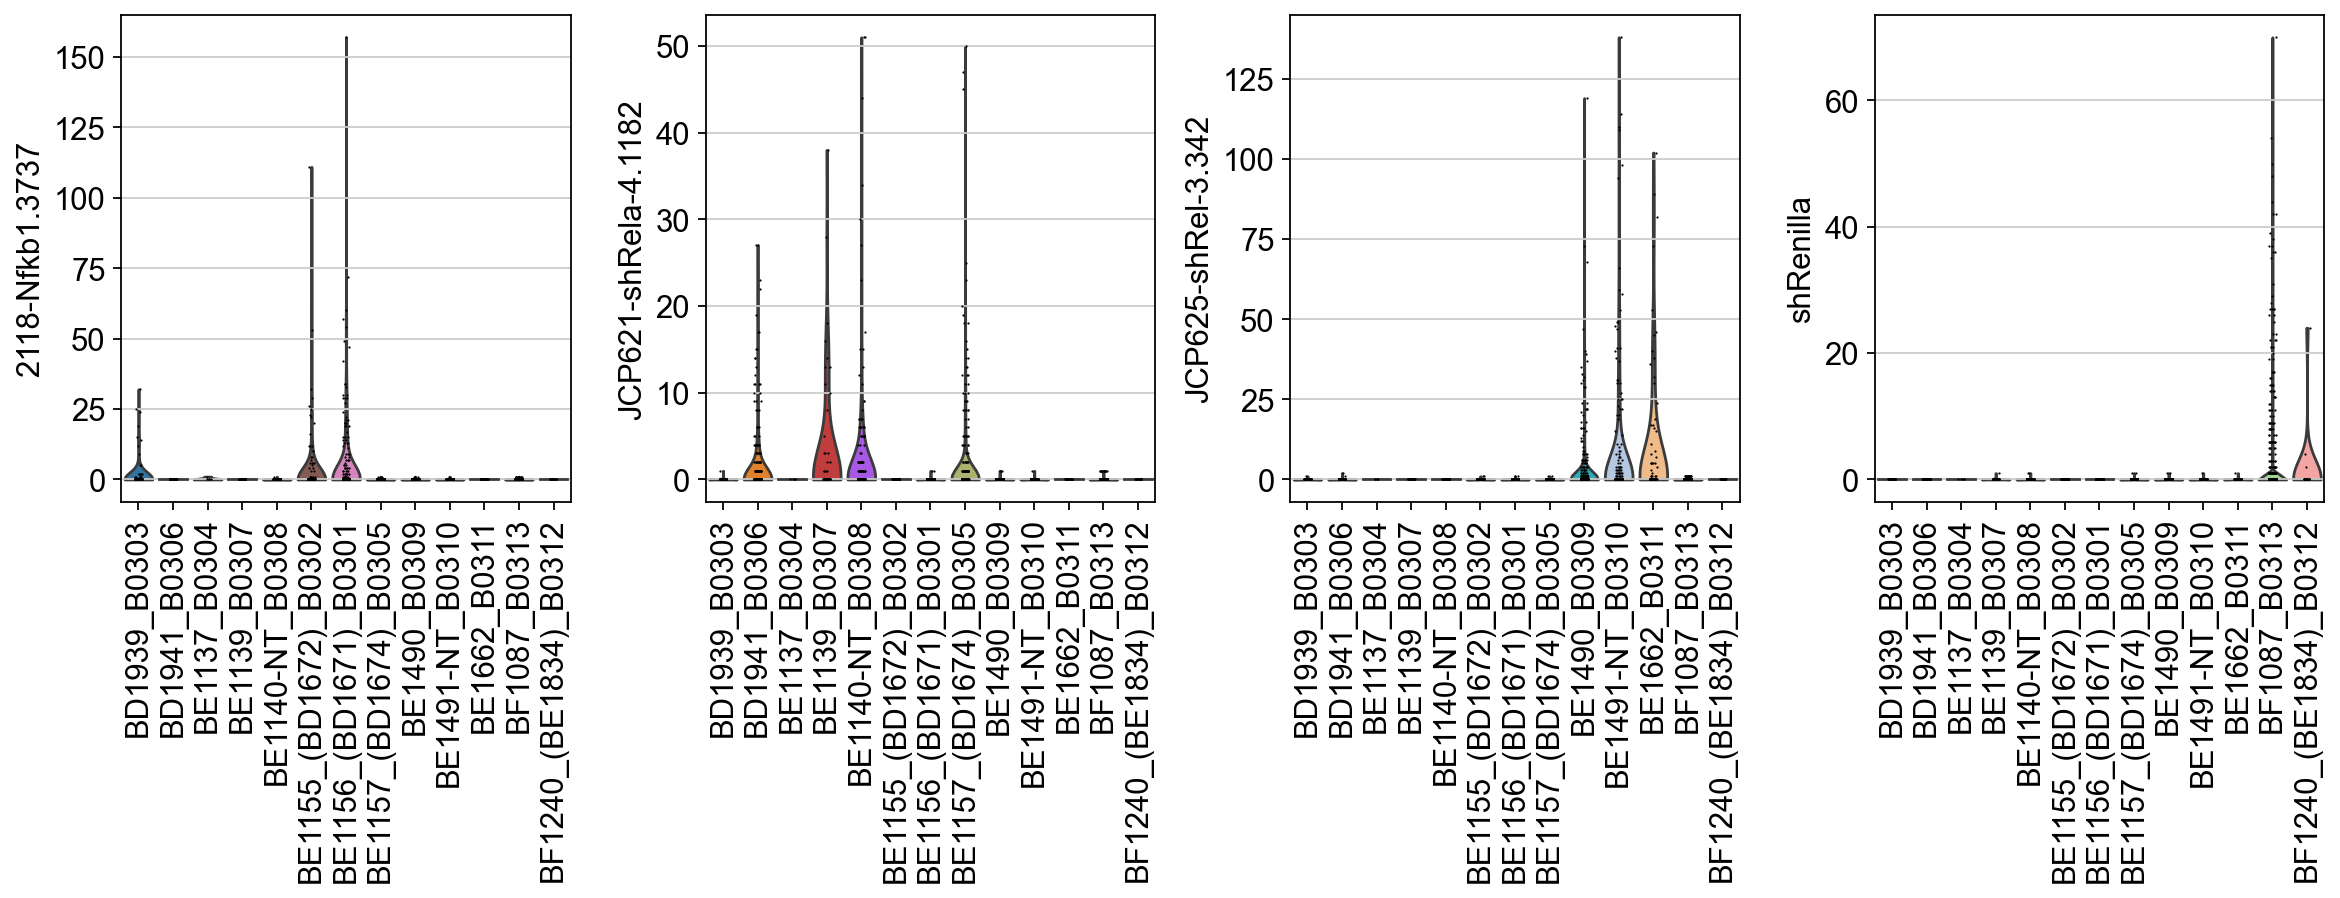

In [59]:
sc.pl.violin(adata,['2118-Nfkb1.3737','JCP621-shRela-4.1182','JCP625-shRel-3.342', 'shRenilla'], groupby='Classification', rotation=90)

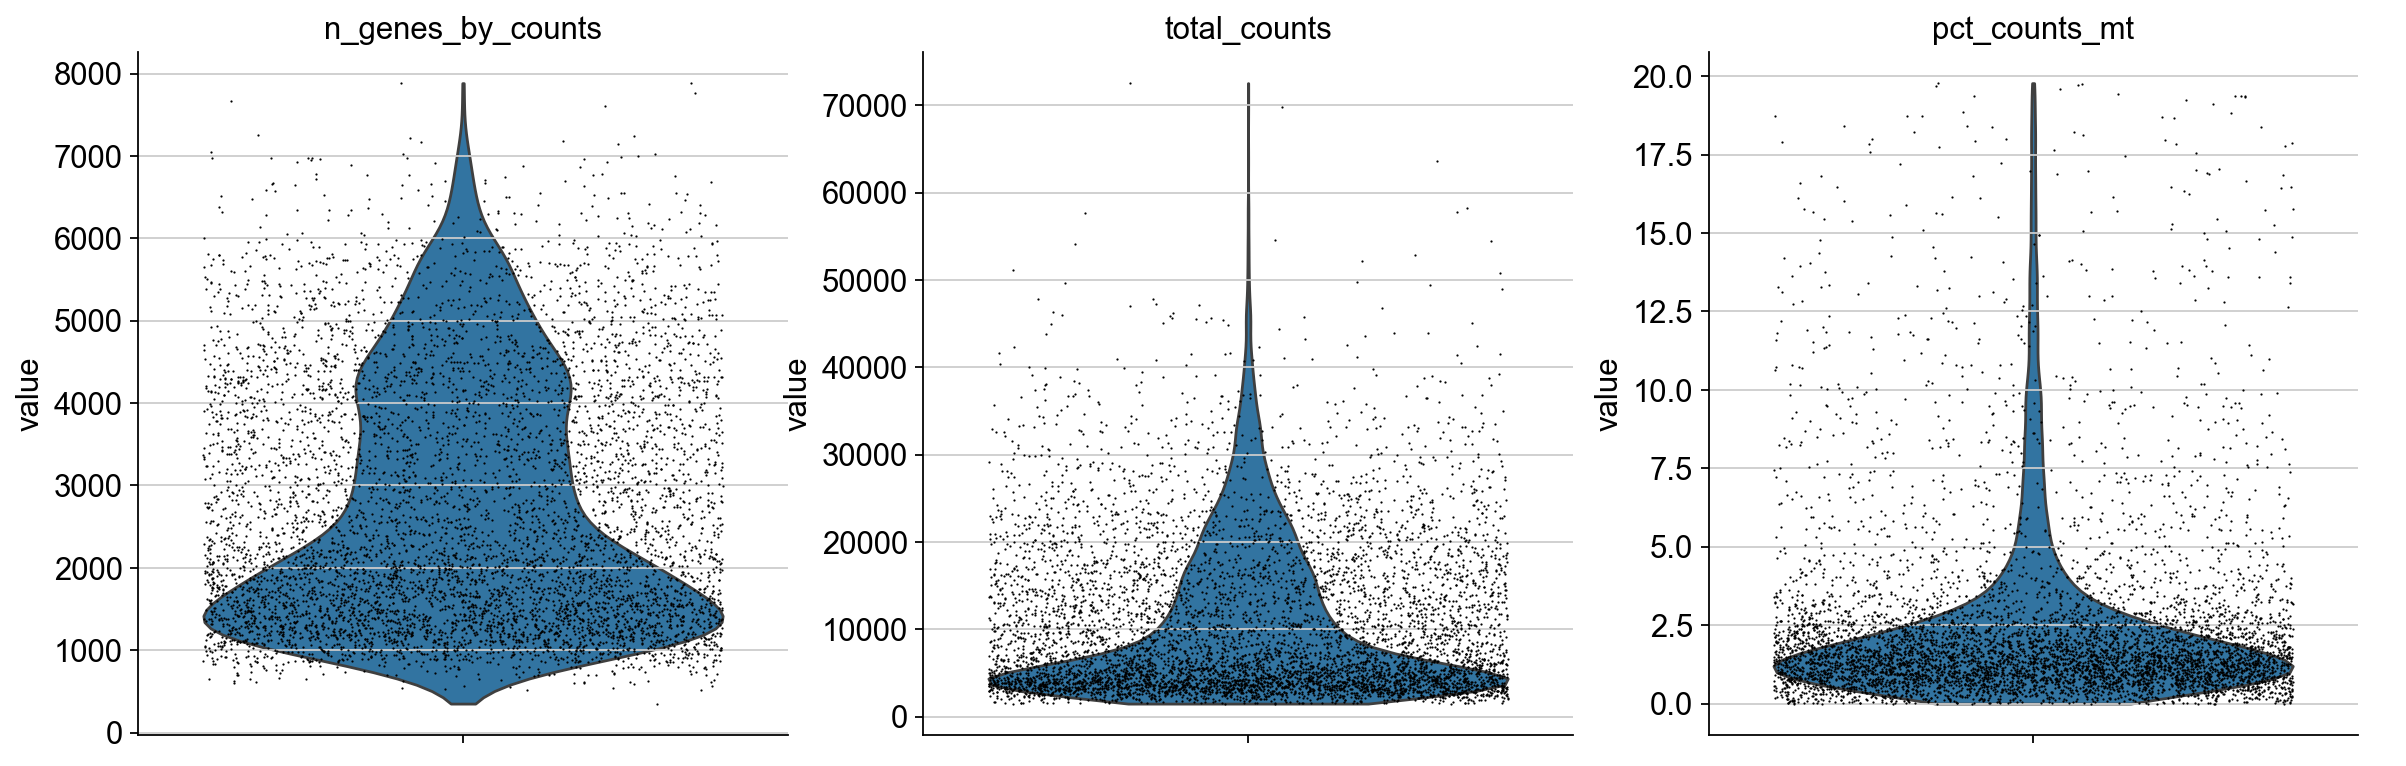

In [60]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True, rotation=90)

In [61]:
adata.layers['counts']=adata.X.copy()

/tmp/ipykernel_4035621/1857676282.py:1: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers['counts']=adata.X.copy()


In [62]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


Logarithmize the data:

In [63]:
sc.pp.log1p(adata)

In [64]:
sc.pp.highly_variable_genes(adata) #batch_key=Classification

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


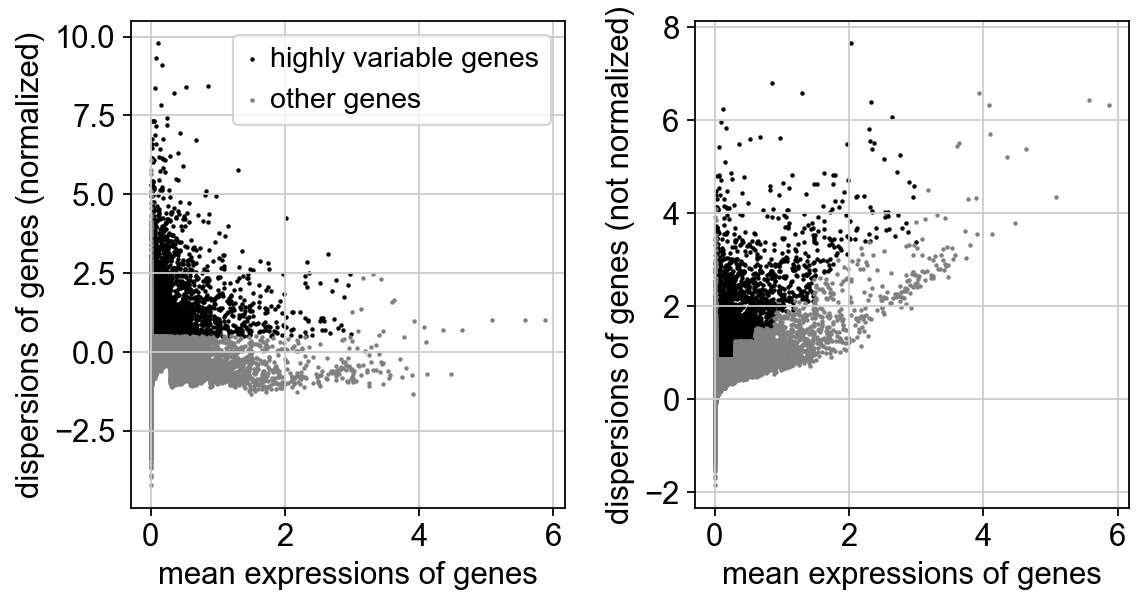

In [65]:
sc.pl.highly_variable_genes(adata)

In [66]:
library = ["1659-Fosl2.226","1660-Fosl2.752","1661-Fhl2.467","1662-Fhl2.179","1663-Myc.989","1664-Myc.1389","1665-Yap1.735","1666-Yap1.2847","1667-Atf4.1383","1668-Atf4.536","1669-Maff.85","1670-Maff.587","1671-Nfkb2.152","1672-Nfkb2.534","1673-Relb.286","1674-Relb.1795","1675-Onecut2.1799","1676-Onecut2.2361","1810-Slc4a11.541","1934-Slc4a11.1966","1811-Itga2.672","1812-Itga2.204","1998-Cldn4-1013","1999-Cldn4-951","2113-Lif.440","2114-Lif.1890","2115-Fosl1.1401","2116-Fosl1.699","2117-Nfkb1.2331","2118-Nfkb1.3737","2190-Jun_2481","2191-Jun_3136","2193-JunB_406","2194-JunD_78","2195-JunD_859","JCP618-Rela_1202","JCP621-Rela_1182","JCP623-Rel_1868","JCP625-Rel_342","JCP628-Ikbkg_2526","JCP629-Ikbkg_2984"]

In [67]:
#Ensure marker genes aren't making an impact to highly variable gene analysis downstream
adata.var.highly_variable['GFP'] = False
adata.var.highly_variable['mKate2'] = False
adata.var.highly_variable['Cre'] = False
for x in library:
    adata.var.highly_variable[x] = False

/tmp/ipykernel_4035621/2494002207.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.var.highly_variable['GFP'] = False
/tmp/ipykernel_4035621/2494002207.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [68]:
adata.raw = adata

In [69]:
adata.write('write/IGO15770-allmice.h5ad', compression='gzip')

In [70]:
sc.pp.scale(adata, max_value=10)

/home/chanj2/part2a/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


## Principal component analysis

In [71]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=150)

computing PCA
    with n_comps=150
    finished (0:00:08)


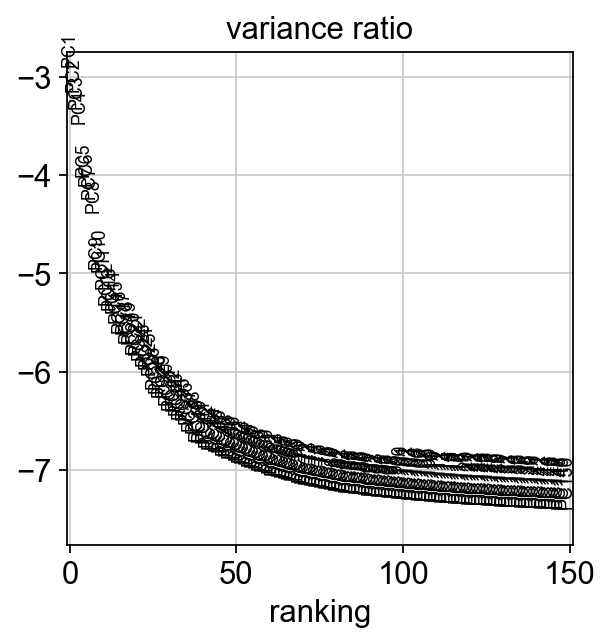

In [72]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=150)

In [73]:
adata.write(results_file, compression='gzip')

In [74]:
adata

AnnData object with n_obs × n_vars = 6527 × 26721
    obs: 'n_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'log10GenesPerUMI', 'Classification', 'shRen', '2118-Nfkb1', 'shRela', 'shRel', 'GFP_count', 'Cre_count', 'shRNA', 'Group'
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Classification_colors', 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

## Computing the neighborhood graph

In [75]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)

computing neighbors
    using 'X_pca' with n_pcs = 50


/home/chanj2/part2a/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)


## Embedding the neighborhood graph

In [76]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:26)


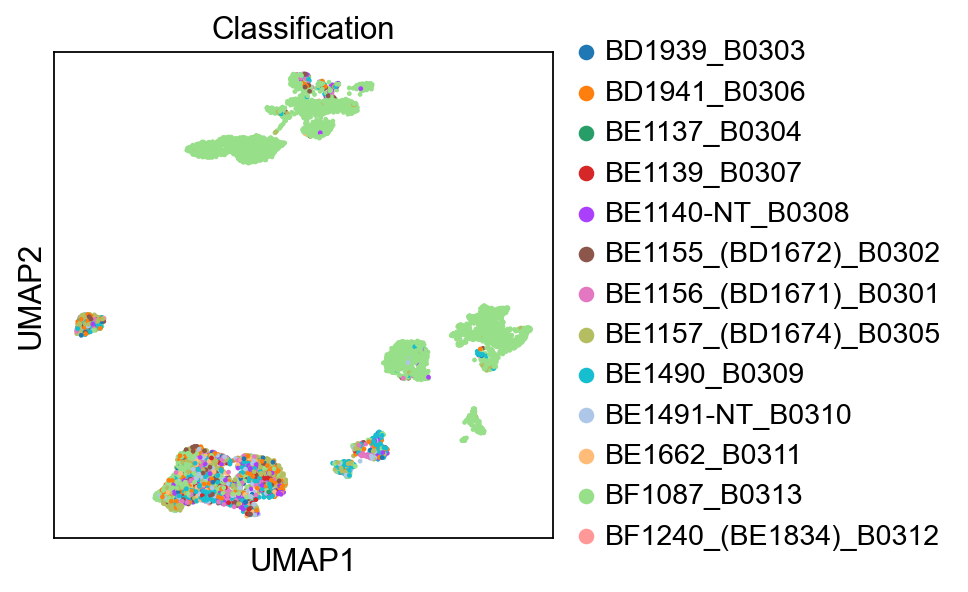

In [77]:
sc.pl.umap(adata, color=['Classification'])

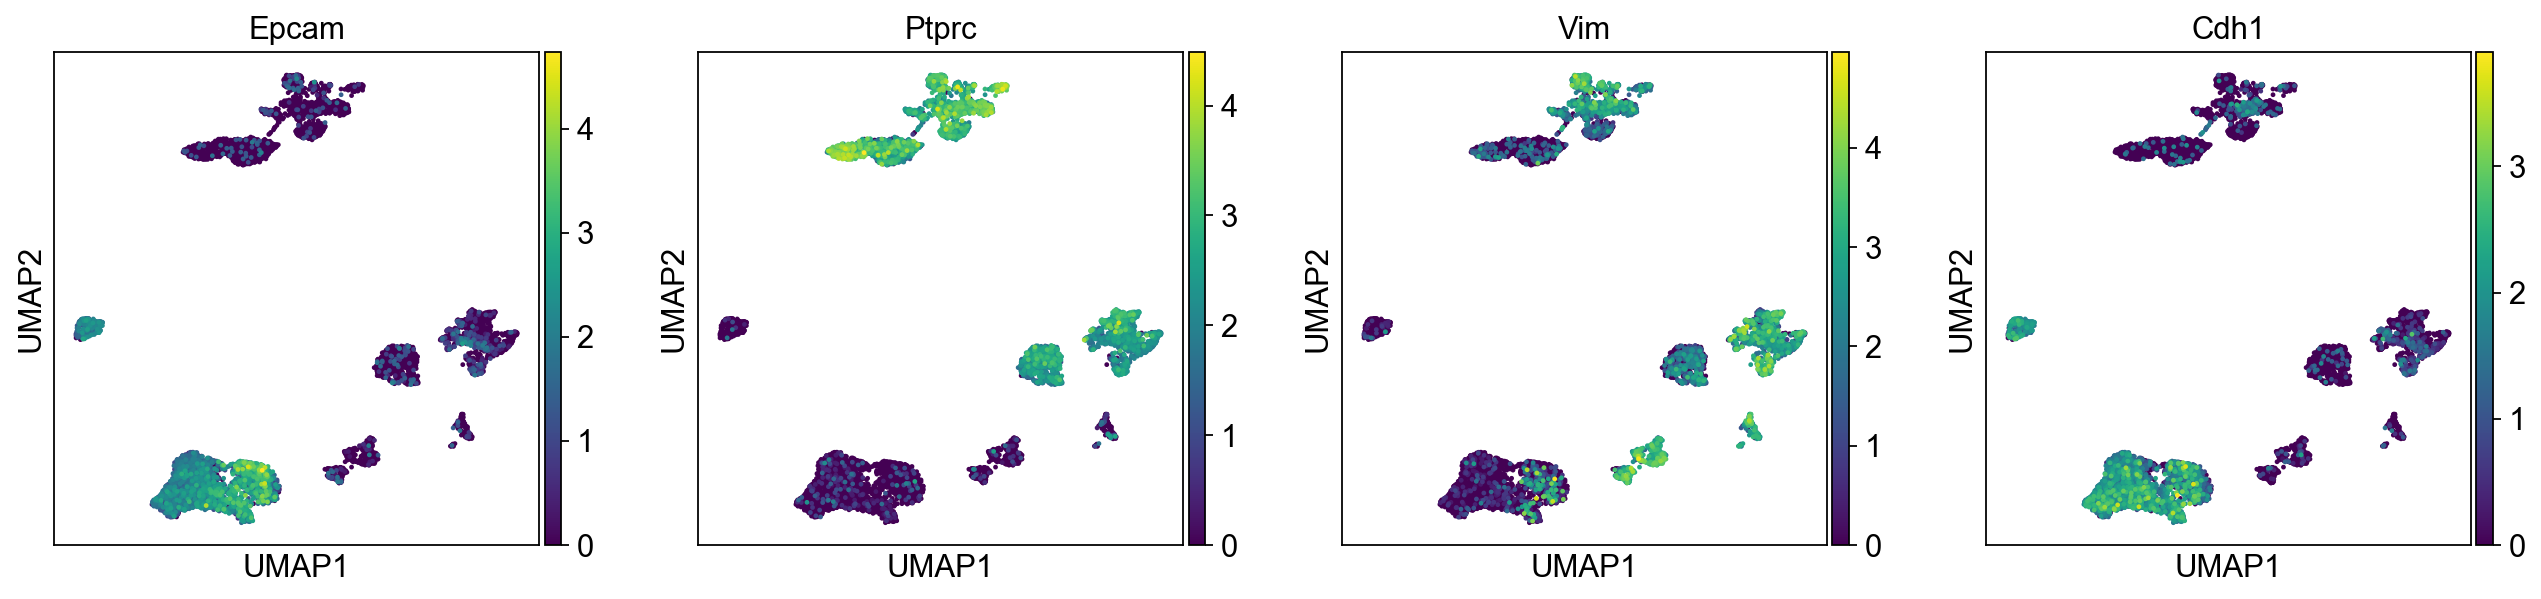

In [78]:
sc.pl.umap(adata, color=['Epcam','Ptprc','Vim', 'Cdh1',]) #'Ptprc','Cdh2'

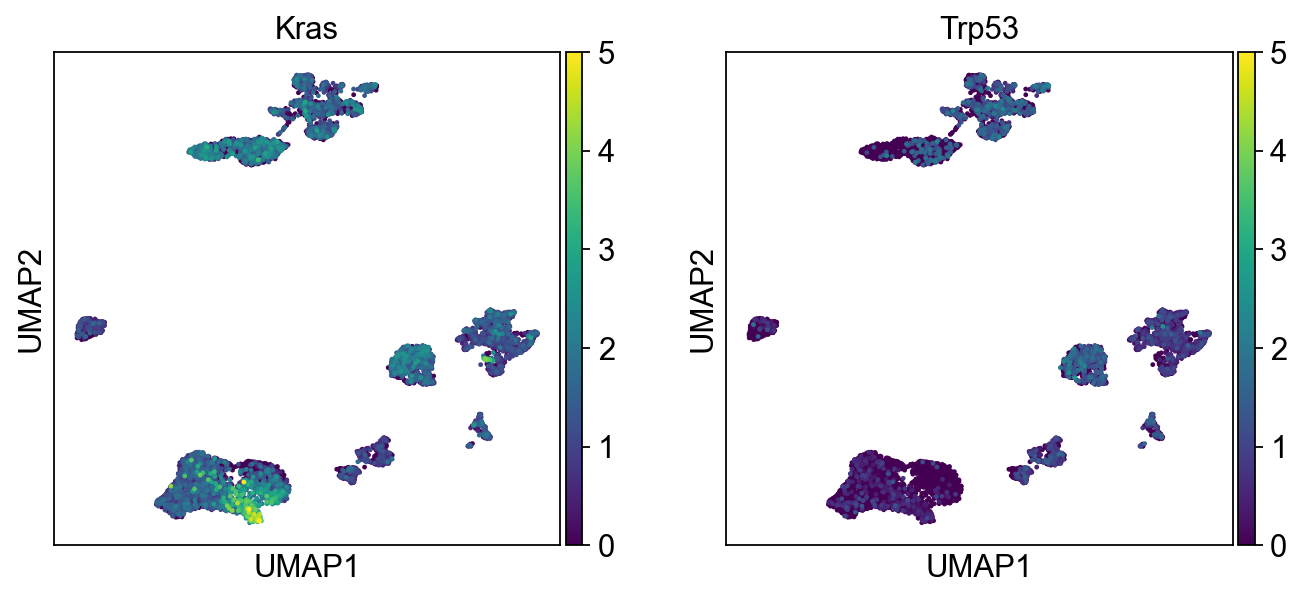

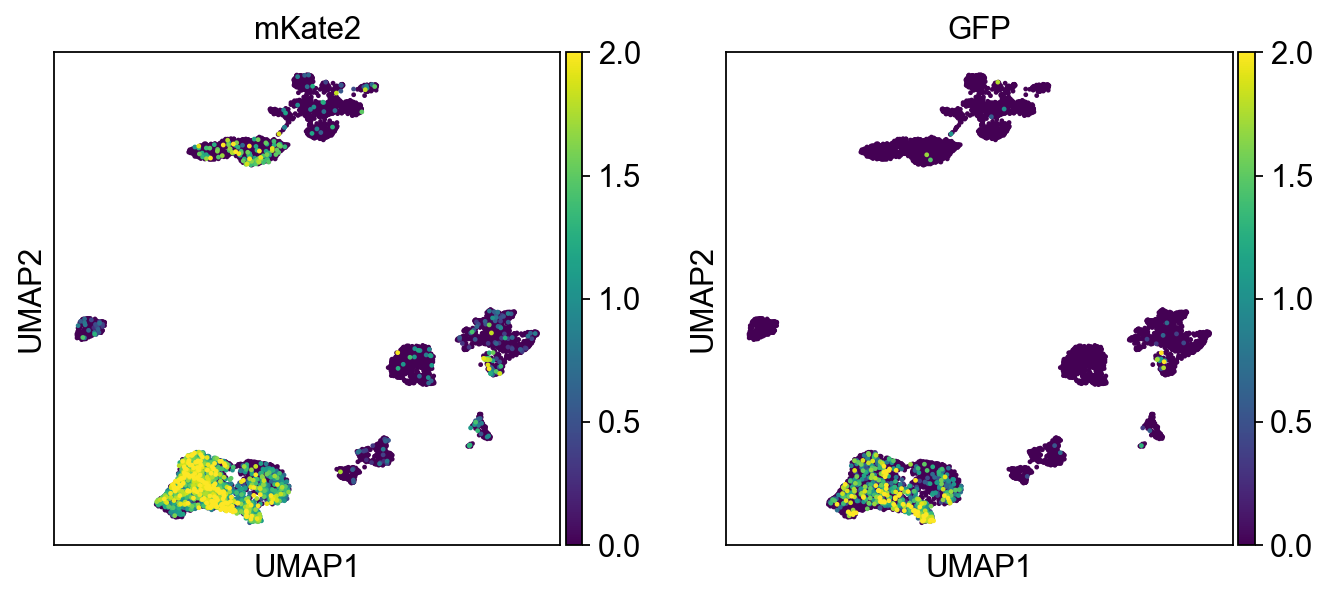

In [79]:
sc.pl.umap(adata, color=['Kras','Trp53'], vmax=5)
sc.pl.umap(adata, color=['mKate2','GFP'], vmax=2)

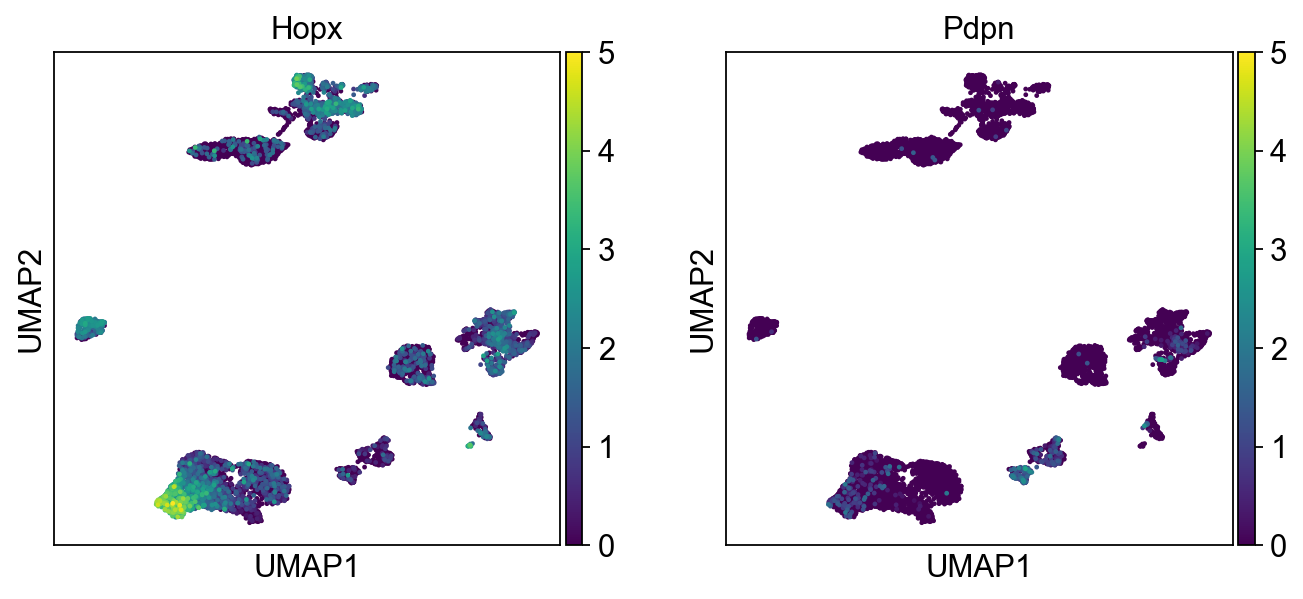

In [80]:
sc.pl.umap(adata, color=['Hopx','Pdpn'], vmax=5)

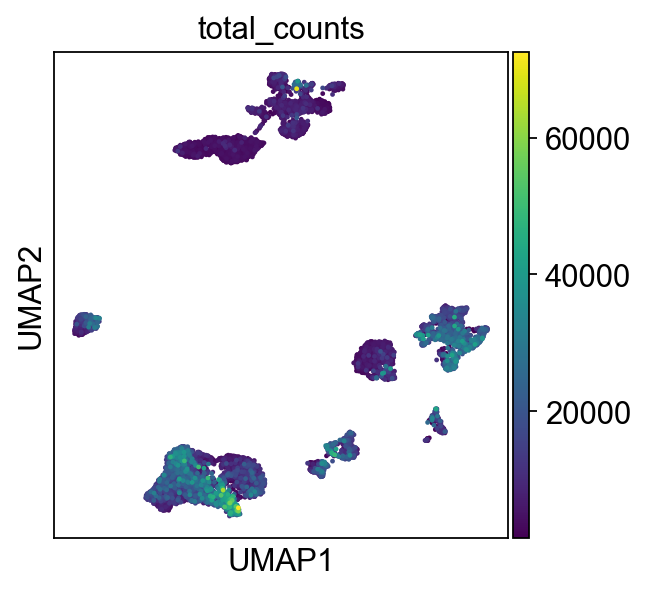

In [81]:
sc.pl.umap(adata, color=['total_counts'])

## Clustering the neighborhood graph

In [82]:
sc.tl.leiden(adata, resolution=0.3)
#sc.tl.leiden(adata, resolution=0.25)

running Leiden clustering
    finished: found 12 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/tmp/ipykernel_4035621/3206119172.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.3)


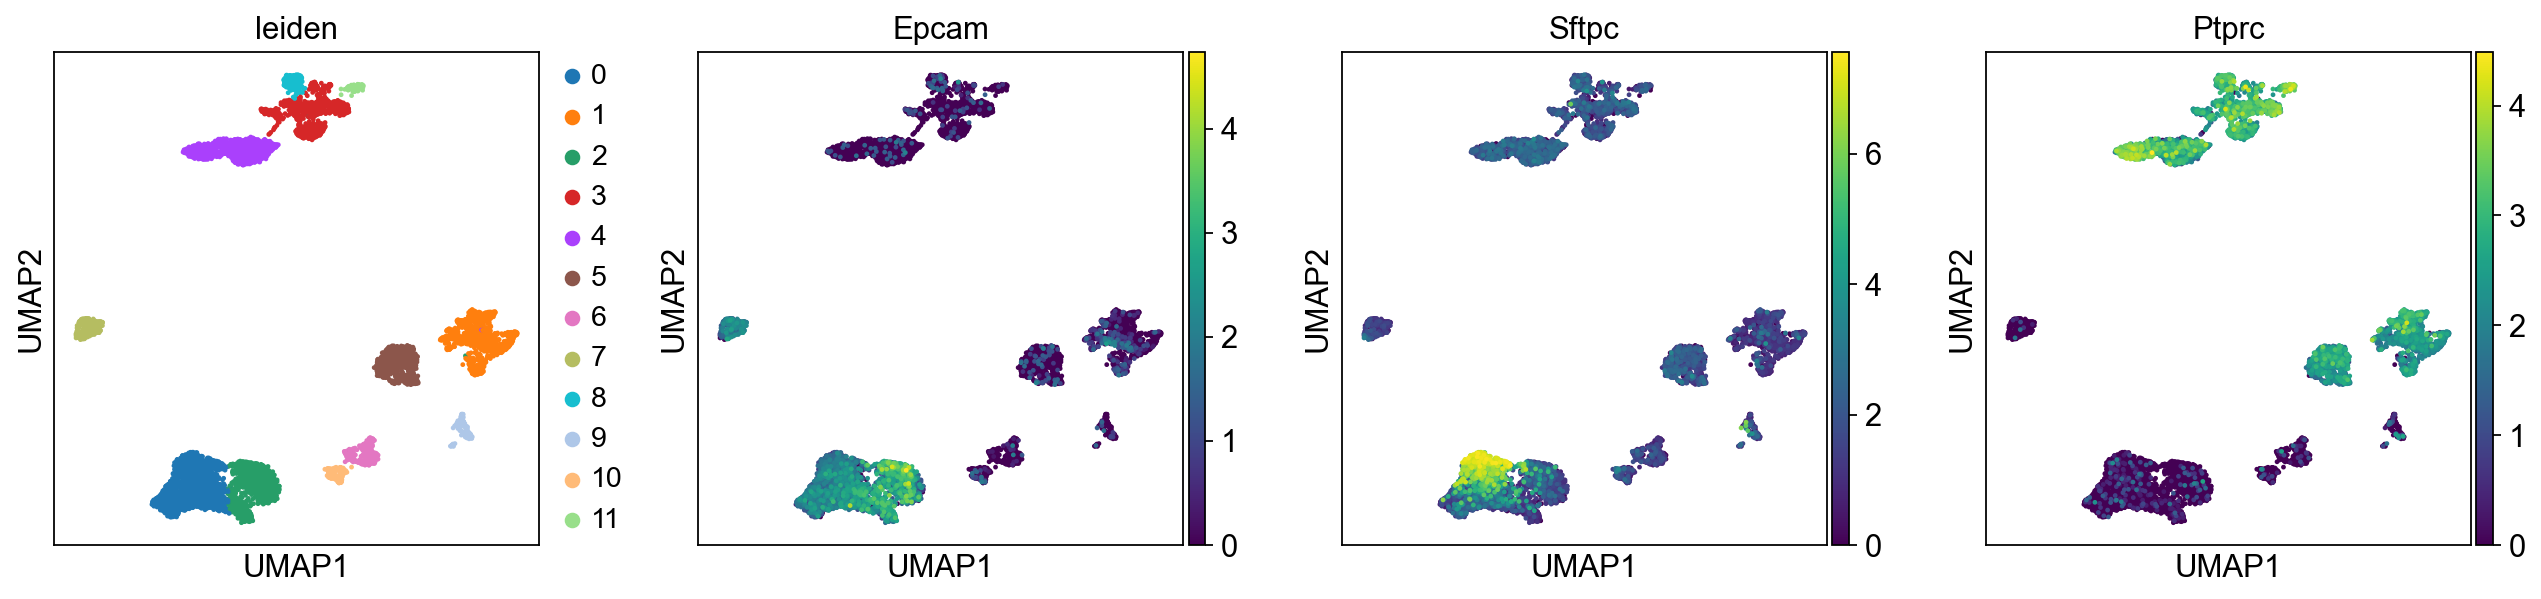

(None,)

In [83]:
sc.pl.umap(adata, color=['leiden', 'Epcam', 'Sftpc', # Tumor cells
                         'Ptprc']), #immune
                         #  'Cd4', 'Cd8a', #T cell #'Cd3e',
                         # 'Cd19', 'Ms4a1', 'Cd22', # B cell
                         # #'Itgax', 'Il3ra', # Dendritic Cell
                         # 'Ncam1',# 'Ncr1', # NK Cell
                         # 'Cd34', # Hematopoetic stem cell
                         # #'Cd14', 'Cd33', # macrophage
                         # #'Ceacam8' # Granulocyte
                         # 'Itga2b', 'Itgb3', 'Selp', #platelet
                         # #'Gypa',  # erythrocyte
                         # #'Mcam', 'Vcam1', 'Pecam1', 'Sele', # endothelial cell
                         # 'Cd109', 'Wnt5a', 'Kras'])

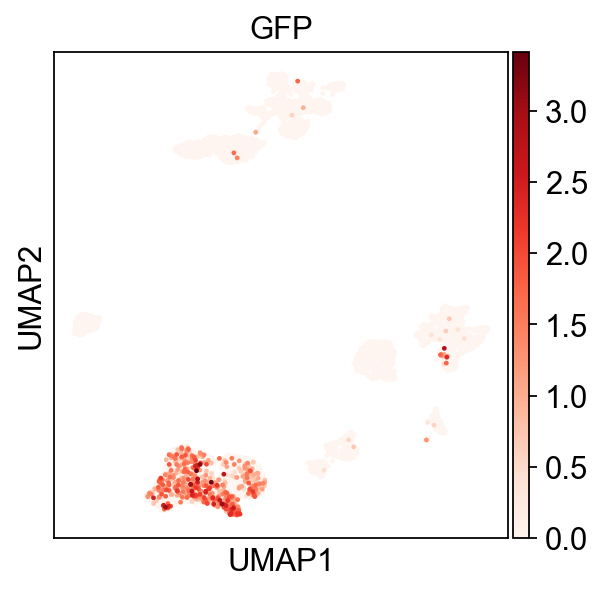

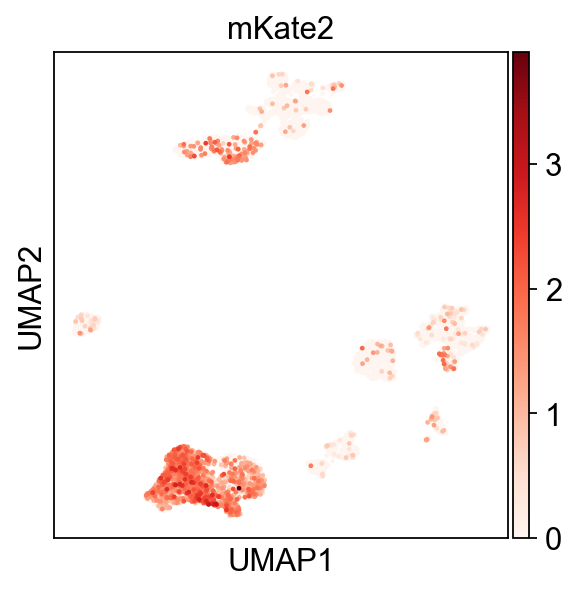

In [84]:
sc.pl.umap(adata, color=['GFP'], cmap='Reds')
sc.pl.umap(adata, color=['mKate2'], cmap='Reds')

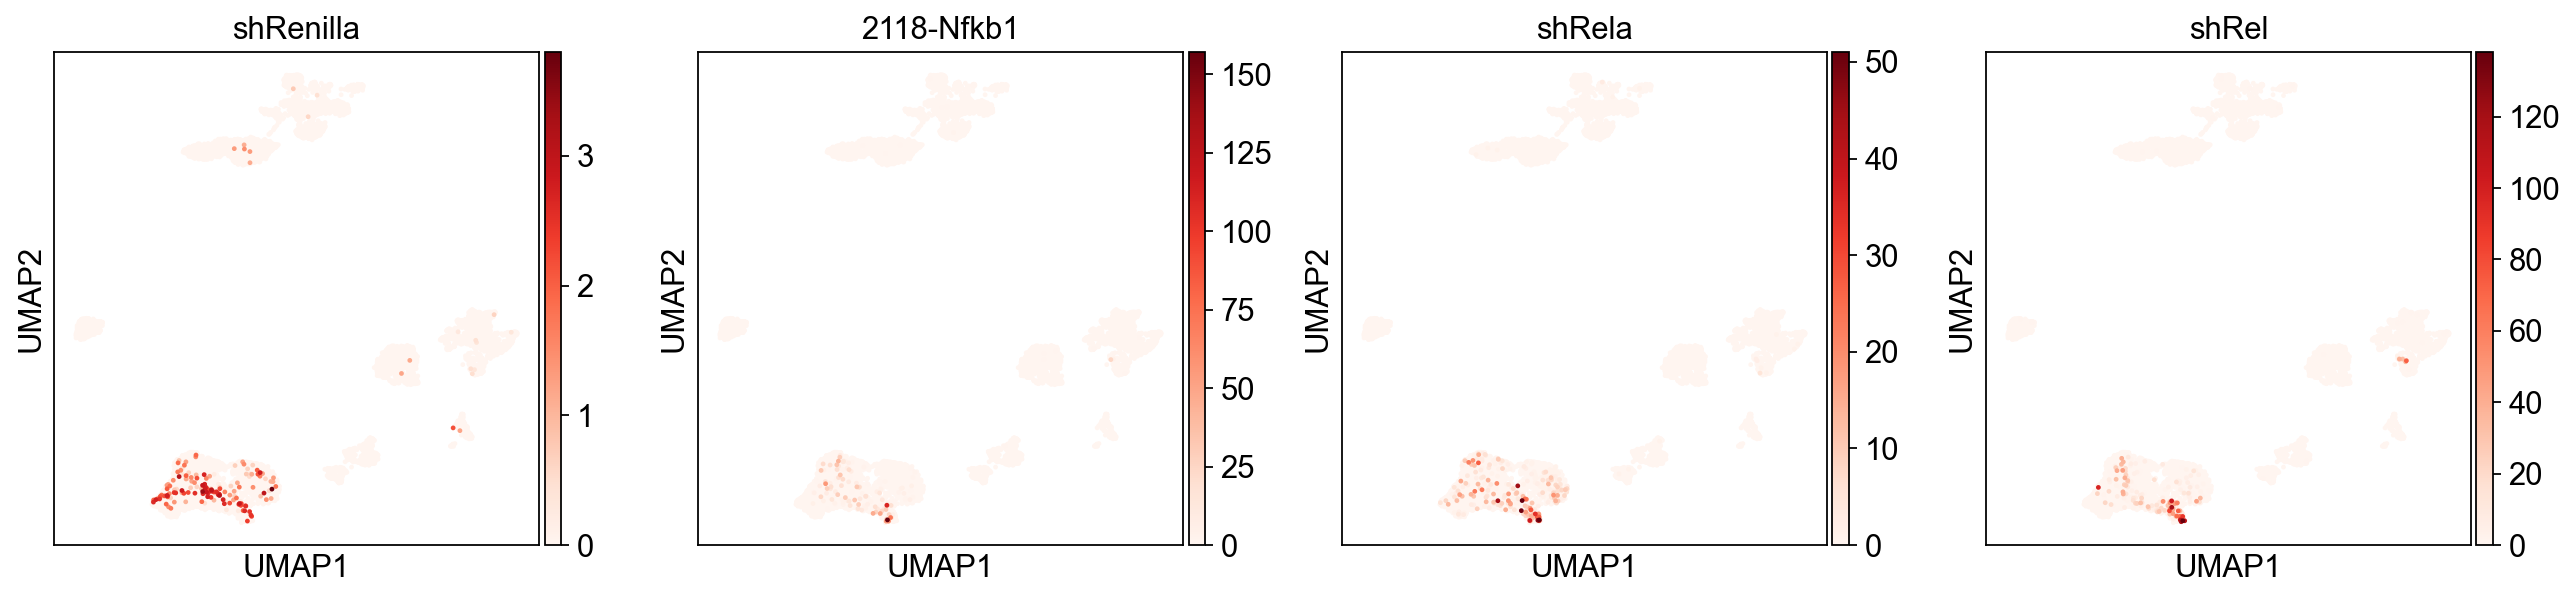

In [85]:
sc.pl.umap(adata, color=["shRenilla", "2118-Nfkb1", "shRela",'shRel'], cmap='Reds')

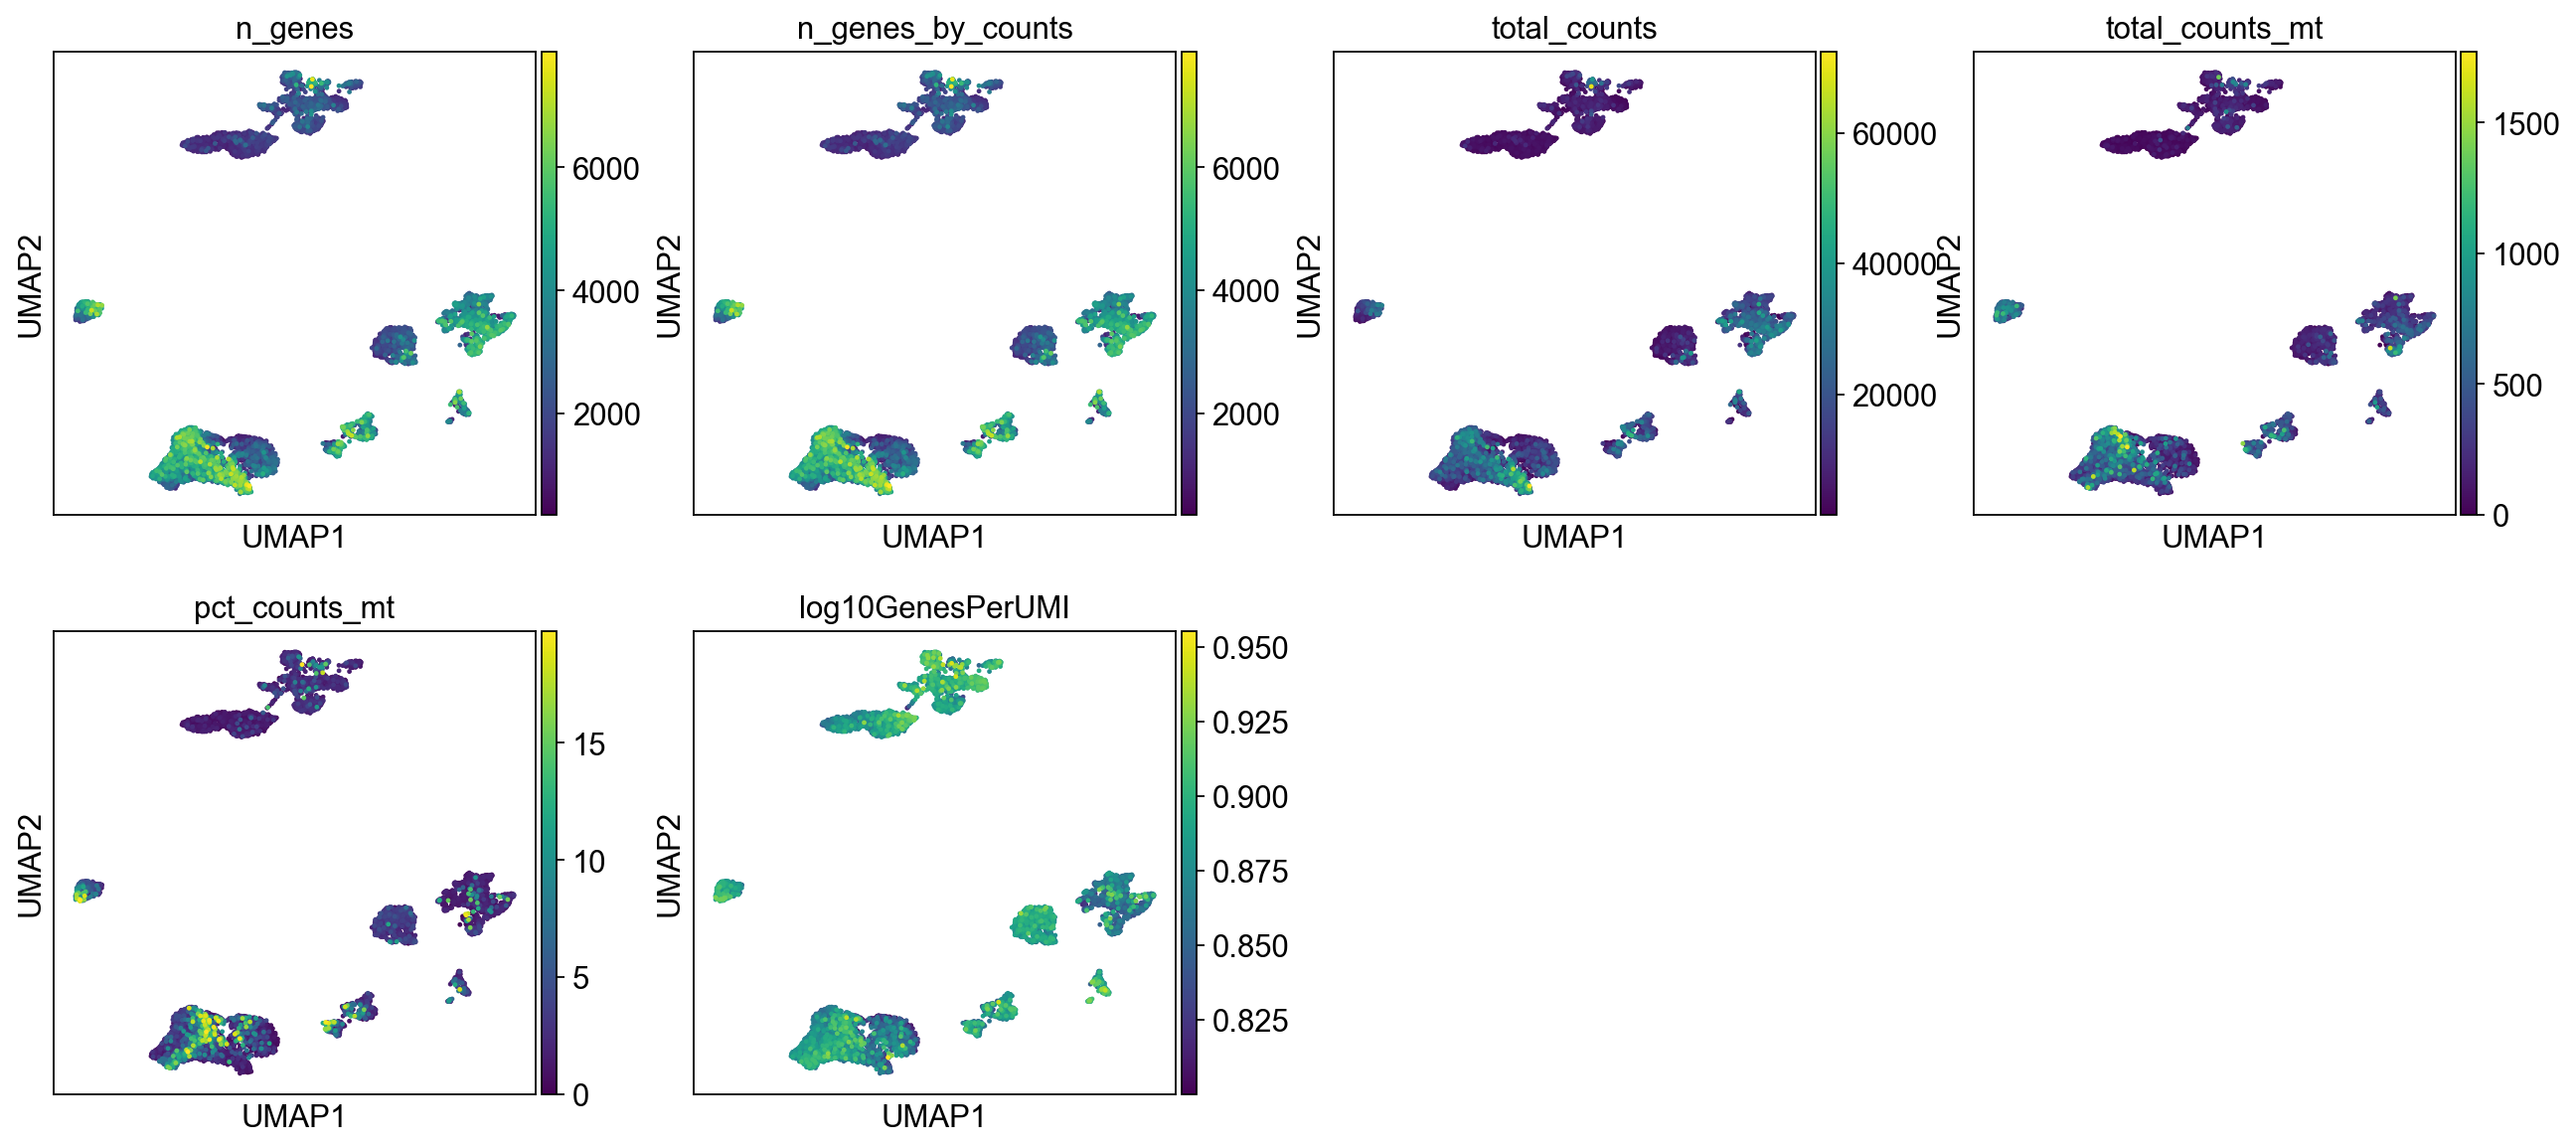

In [86]:
sc.pl.umap(adata,color=['n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt',
       'pct_counts_mt', 'log10GenesPerUMI'])

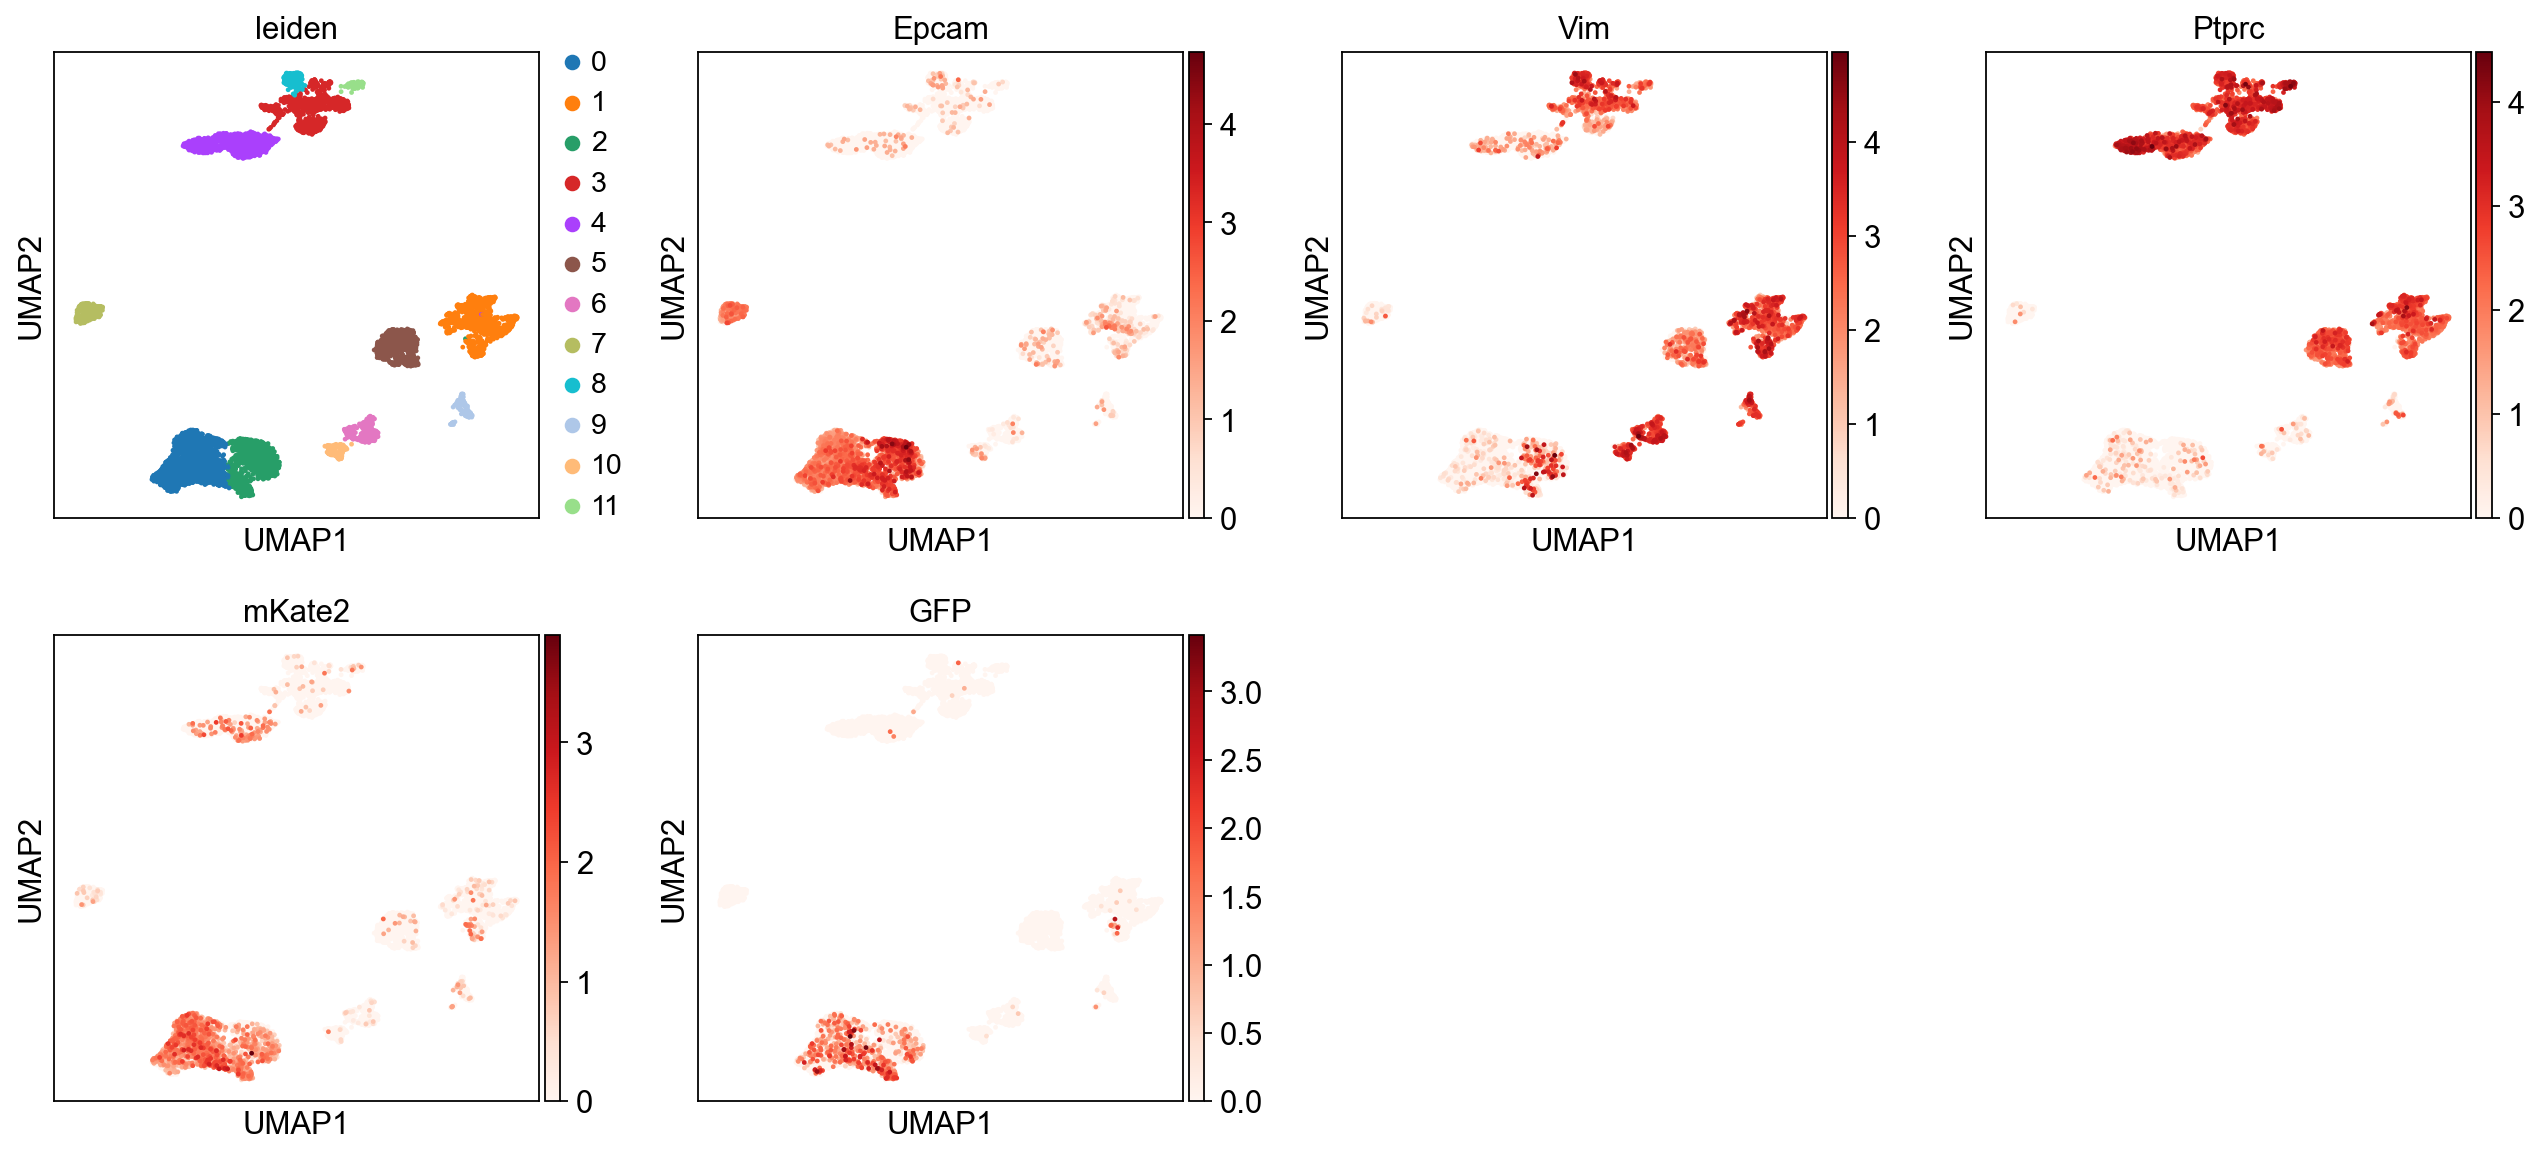

In [87]:
sc.pl.umap(adata, color=['leiden','Epcam','Vim','Ptprc','mKate2','GFP'],cmap="Reds")

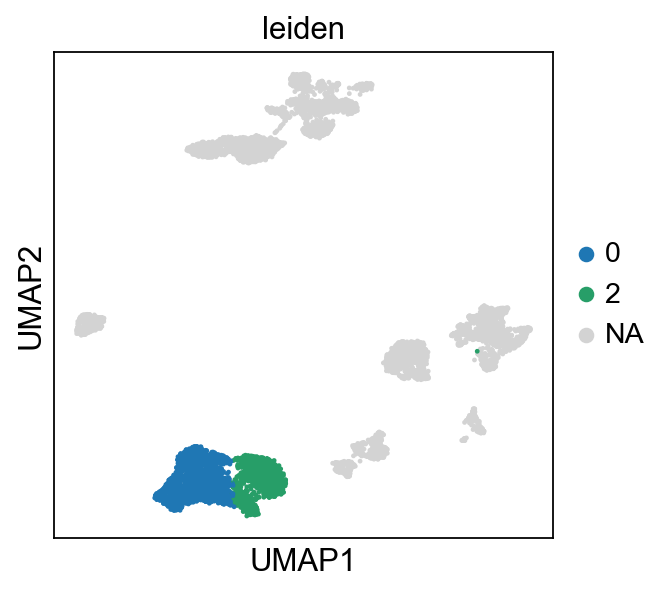

In [88]:
sc.pl.umap(adata, color=['leiden'], groups=['0','2'])

## Select Tumor Cells

In [89]:
# Select only those subset of cells that are useful
adata2 = sc.read('write/IGO15770-allmice.h5ad')
adata = adata2[adata.obs['leiden'].isin(['0','2']),:] # keep tumor cells
del adata2

In [90]:
#fix a bug; 'base' is None but that doesn't seem to have transferred
adata.uns['log1p'] = {}
adata.uns['log1p']['base'] = None

/tmp/ipykernel_4035621/2000007.py:2: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['log1p'] = {}


In [91]:
sc.pp.highly_variable_genes(adata)#, batch_key='Classification')

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [92]:
#Ensure marker genes aren't making an impact to highly variable gene analysis downstream
adata.var.highly_variable['GFP'] = False
adata.var.highly_variable['mKate2'] = False
adata.var.highly_variable['Cre'] = False
for x in library:
    adata.var.highly_variable[x] = False

/tmp/ipykernel_4035621/2494002207.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.var.highly_variable['GFP'] = False
/tmp/ipykernel_4035621/2494002207.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

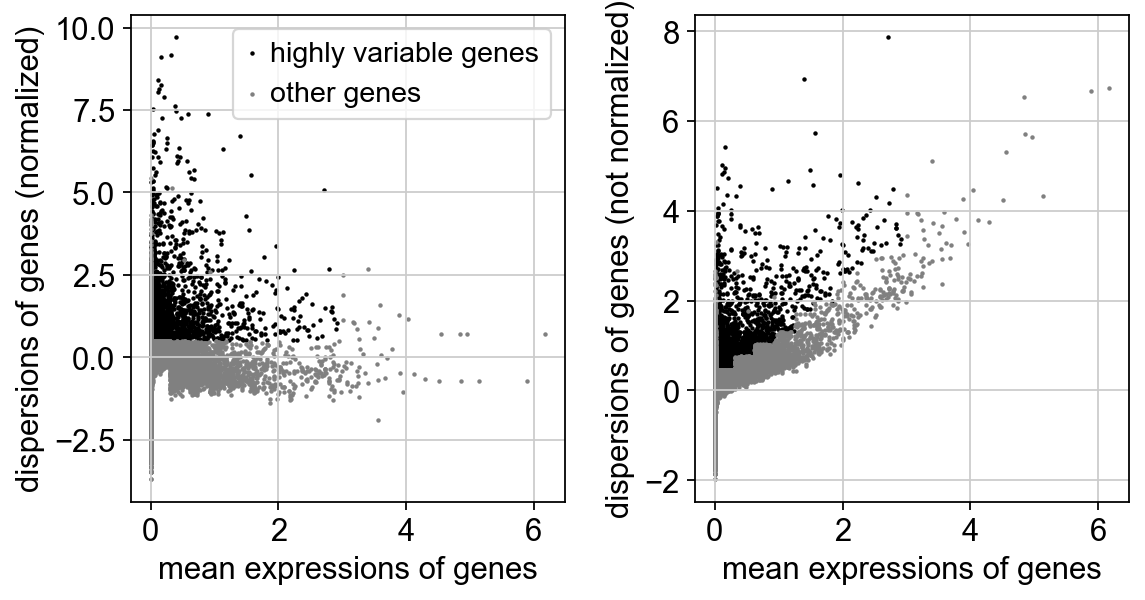

In [93]:
sc.pl.highly_variable_genes(adata)

In [94]:
adata.raw = adata

In [95]:
adata.write('write/IGO15770-allmice-tumor.h5ad', compression='gzip')
#adata = sc.read('write/IGO15770-allmice-tumor.h5ad')